## Capstone Project 1 Proposal: Supplier Pricing Prediction & Cost Segmentation

### Project Scope: 
Caterpillar (construction equipment manufacturer) relies on a variety of suppliers to manufacture tube assemblies for their equipment. These assemblies are required in their equipment to lift, load and transport heavy construction loads. We are provided with detailed tube, component, and annual volume datasets. Our goal is to build and train a model that can predict how much a supplier will quote for a given tube assembly based on given supplier pricing, and use this information to further categorize spend into 4 tiers (1 to 4) such that movement in criteria example recency, frequency, total spend, % supplier rebates etc can be accurately classified and responded with appropriate supplier strategy. 

### Challenges: 
We are provided with 21 tables. Challenge is to come up with a single table with an equation that can predict supplier pricing. Reason, our model should demonstrate that by varying assembly specifications, supplier predicted pricing is also getting impacted. Example, tube assembly without an additonal attachement should cost less compared to others. Also, assembly which used to be tier 1 (highest total spend) is now tier 2 due to shift in spend. 
I am not sure how to connect primary table with the secondary table so that above relationship can be established in our model. 

### Problem Solving: 
1. Built primary table using left merge on tube_assembly_id.
2. **Updated:  Dropped 22 and 59 columns from primary and secondary table contaning null values > 70%.
3. **Updated: Build secondary table by concatenating columns instead of using left merge. This helped reduce null values in the secondary table. 
4. **Updated: Created classification criteria, category labelling completed. 
5. **Updated: Built Final Table which consists of Primary, Secondary and Tube End Form Table.
6. **Updated: Tables (Final and Segmented) ready for modelling.
7. Ran Model A and B with and without one hot encoding however, getting some null and negative predicted vlaues. 

### Feature Engineering: 
1. **Updated: Added features such as purchase recency, frequency, total spend, rebate and market difficulty using primary table. 
2. ** Updated: Reduced null values from the secondary table and kept limited features such as weight, unique features, orientation and components to merge it with the primary table. 

### Model Selection: 
I intentd to use various models to justify our feature selection such as Random forest, XG boost, PCA. Use LDA to categorize spend which will use RFM to learn from the lables, and linear regression to predict supplier pricing. 


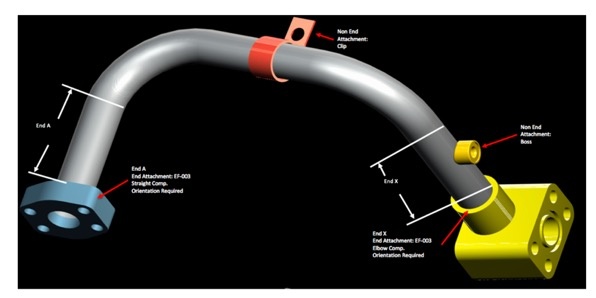

## Section A. Approach:  Build Primary Table using left merge: 

### Combine Tube Assembly Tables with common primary keys:

### Step1. Load Libraries 

In [849]:
#load libraries

import pandas as pd

import numpy as np

import matplotlib.pyplot as plt

%matplotlib inline

import seaborn as sns

import glob as gl

from functools import reduce  # ask about this library

import datetime as dt

import warnings
warnings.filterwarnings('ignore')

### Step2. Load Dataset having common tube_assembly_id as a primary key:

In [850]:

#1.Tube
df_tube = pd.read_csv('tube.csv')

#2. Bill of material
df_bill = pd.read_csv('bill_of_materials.csv')

#3. Specifications
df_spec = pd.read_csv('specs.csv')

#4. Tube End form: (This is merged with the final table in the later section)
df_end_form = pd.read_csv('tube_end_form.csv')

#5. Training
df_train= pd.read_csv('train_set.csv',parse_dates=True) 


### Step2: Pre-processing tables and cleaning dataset
#### A) Merge tables with training dataset using left join. 

In [851]:
# First Merge: Train data with bill of material
df_first= pd.merge(left = df_train, right = df_bill, how = 'left', on = 'tube_assembly_id')

# Second Merge: First Merged table with tube
df_second= pd.merge(left = df_first, right = df_tube, how = 'left', on = 'tube_assembly_id')

# Third Merge: Second Merged table with Specs
df_third= pd.merge(left = df_second, right = df_spec, how = 'left', on = 'tube_assembly_id')

df_third.head()

#Tube end form will be merged later.

,tube_assembly_id,supplier,quote_date,annual_usage,min_order_quantity,bracket_pricing,quantity,cost,component_id_1,quantity_1,...,spec1,spec2,spec3,spec4,spec5,spec6,spec7,spec8,spec9,spec10
0,TA-00002,S-0066,2013-07-07,0,0,Yes,1,21.905933,C-1312,2.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,TA-00002,S-0066,2013-07-07,0,0,Yes,2,12.341214,C-1312,2.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,TA-00002,S-0066,2013-07-07,0,0,Yes,5,6.601826,C-1312,2.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,TA-00002,S-0066,2013-07-07,0,0,Yes,10,4.687770,C-1312,2.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,TA-00002,S-0066,2013-07-07,0,0,Yes,25,3.541561,C-1312,2.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


#### B) Clean dataset: 

#### 1. Converting Data Types of Merged Columns: 

###### Note: Categorical values to be converted into dummy variables later, prior modelling

In [852]:
#Initial Data Type: 
df_third.info(max_cols=5)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 30213 entries, 0 to 30212
Columns: 49 entries, tube_assembly_id to spec10
dtypes: float64(13), int64(7), object(29)
memory usage: 11.5+ MB


In [853]:
#Converting quotation date to date time format:
df_third['quote_date']= pd.to_datetime(df_third['quote_date'])

#Converting Object columns in the dataframe into Category: 
df_third[df_third.select_dtypes(['object']).columns] = df_third.select_dtypes(['object']).apply(lambda x: x.astype('category'))

In [854]:
#Final Data type after cleaning:
df_third.info(max_cols=5)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 30213 entries, 0 to 30212
Columns: 49 entries, tube_assembly_id to spec10
dtypes: category(28), datetime64[ns](1), float64(13), int64(7)
memory usage: 6.5 MB


In [855]:
#Identify categorical columns:
df_third.select_dtypes(['category']).columns

Index(['tube_assembly_id', 'supplier', 'bracket_pricing', 'component_id_1',
       'component_id_2', 'component_id_3', 'component_id_4', 'component_id_5',
       'component_id_6', 'component_id_7', 'component_id_8', 'material_id',
       'end_a_1x', 'end_a_2x', 'end_x_1x', 'end_x_2x', 'end_a', 'end_x',
       'spec1', 'spec2', 'spec3', 'spec4', 'spec5', 'spec6', 'spec7', 'spec8',
       'spec9', 'spec10'],
      dtype='object')

In [856]:
#Count of unique categorical values in the merged table:  
df_third[df_third.select_dtypes(['category']).columns].nunique()

tube_assembly_id    8855
supplier              57
bracket_pricing        2
component_id_1       642
component_id_2       452
component_id_3       302
component_id_4       104
component_id_5        29
component_id_6        10
component_id_7         3
component_id_8         1
material_id           17
end_a_1x               2
end_a_2x               2
end_x_1x               2
end_x_2x               2
end_a                 25
end_x                 24
spec1                 36
spec2                 43
spec3                 41
spec4                 30
spec5                 28
spec6                 13
spec7                  7
spec8                  3
spec9                  2
spec10                 0
dtype: int64

## Treating Null Values: 

In [857]:
#checking for columns with less than 31 percent of null data
column_31= df_third.isnull().sum()/df_third.shape[0]*100 < 31 #data up to 69% of not null values

#checking for columns with less than 76 percent of null data
column_76=  df_third.isnull().sum()/df_third.shape[0]*100 < 76 #data upto 24% of not null values 

#Checking impact of dropping columns
column_76.value_counts()-column_31.value_counts()


True     0
False    0
dtype: int64

In [858]:
column_76

tube_assembly_id       True
supplier               True
quote_date             True
annual_usage           True
min_order_quantity     True
bracket_pricing        True
quantity               True
cost                   True
component_id_1         True
quantity_1             True
component_id_2         True
quantity_2             True
component_id_3        False
quantity_3            False
component_id_4        False
quantity_4            False
component_id_5        False
quantity_5            False
component_id_6        False
quantity_6            False
component_id_7        False
quantity_7            False
component_id_8        False
quantity_8            False
material_id            True
diameter               True
wall                   True
length                 True
num_bends              True
bend_radius            True
end_a_1x               True
end_a_2x               True
end_x_1x               True
end_x_2x               True
end_a                  True
end_x               

In [859]:
column_31.value_counts() #this means 22 columns contaning 31% to 76% of the null values have been dropped. 

True     27
False    22
dtype: int64

### Observation: 
1. Columns between 31% and 76% of null values have no impact on the merged table df_third. 
2. As a result, following columns would represent hard to predict assemblies with fewer examples. 
3. After building our model, we can assess impact by adding back dropped columns.

### Dropped Columns: 
a)  component_id_3 to component_id_4
 
b) quantity_3 to quantity_8
 
c) specs_1 to specs_10
 


     

In [860]:
df_prime =df_third.loc[:,column_31]
df_prime.head()

,tube_assembly_id,supplier,quote_date,annual_usage,min_order_quantity,bracket_pricing,quantity,cost,component_id_1,quantity_1,...,bend_radius,end_a_1x,end_a_2x,end_x_1x,end_x_2x,end_a,end_x,num_boss,num_bracket,other
0,TA-00002,S-0066,2013-07-07,0,0,Yes,1,21.905933,C-1312,2.0,...,19.05,N,N,N,N,EF-008,EF-008,0,0,0
1,TA-00002,S-0066,2013-07-07,0,0,Yes,2,12.341214,C-1312,2.0,...,19.05,N,N,N,N,EF-008,EF-008,0,0,0
2,TA-00002,S-0066,2013-07-07,0,0,Yes,5,6.601826,C-1312,2.0,...,19.05,N,N,N,N,EF-008,EF-008,0,0,0
3,TA-00002,S-0066,2013-07-07,0,0,Yes,10,4.687770,C-1312,2.0,...,19.05,N,N,N,N,EF-008,EF-008,0,0,0
4,TA-00002,S-0066,2013-07-07,0,0,Yes,25,3.541561,C-1312,2.0,...,19.05,N,N,N,N,EF-008,EF-008,0,0,0


### Step3: Re-positioning columns within the dataframe  :

In [861]:
df_prime=df_prime.drop(columns=['quote_date',
                             'annual_usage',
                             'min_order_quantity',
                             'quantity',
                             'cost'], axis = 1).assign(quote_date=df_prime['quote_date'],
                                             annual_usage=df_prime['annual_usage'], 
                                             min_order_quantity=df_prime['min_order_quantity'],
                                             quantity= df_prime['quantity'],
                                             cost = df_prime['cost'])
df_prime.head()

,tube_assembly_id,supplier,bracket_pricing,component_id_1,quantity_1,component_id_2,quantity_2,material_id,diameter,wall,...,end_a,end_x,num_boss,num_bracket,other,quote_date,annual_usage,min_order_quantity,quantity,cost
0,TA-00002,S-0066,Yes,C-1312,2.0,NaN,NaN,SP-0019,6.35,0.71,...,EF-008,EF-008,0,0,0,2013-07-07,0,0,1,21.905933
1,TA-00002,S-0066,Yes,C-1312,2.0,NaN,NaN,SP-0019,6.35,0.71,...,EF-008,EF-008,0,0,0,2013-07-07,0,0,2,12.341214
2,TA-00002,S-0066,Yes,C-1312,2.0,NaN,NaN,SP-0019,6.35,0.71,...,EF-008,EF-008,0,0,0,2013-07-07,0,0,5,6.601826
3,TA-00002,S-0066,Yes,C-1312,2.0,NaN,NaN,SP-0019,6.35,0.71,...,EF-008,EF-008,0,0,0,2013-07-07,0,0,10,4.687770
4,TA-00002,S-0066,Yes,C-1312,2.0,NaN,NaN,SP-0019,6.35,0.71,...,EF-008,EF-008,0,0,0,2013-07-07,0,0,25,3.541561


In [862]:
#Sorting table by Bracket Pricing
df_prime.sort_values(by ='bracket_pricing').head()

,tube_assembly_id,supplier,bracket_pricing,component_id_1,quantity_1,component_id_2,quantity_2,material_id,diameter,wall,...,end_a,end_x,num_boss,num_bracket,other,quote_date,annual_usage,min_order_quantity,quantity,cost
30212,TA-21197,S-0026,No,C-1733,1.0,NaN,NaN,SP-0029,34.92,1.65,...,EF-003,EF-017,0,0,0,2009-07-30,3,1,1,53.618624
11692,TA-06932,S-0066,No,C-1943,1.0,C-0610,1.0,SP-0029,44.45,1.65,...,EF-023,EF-009,0,0,0,2010-08-16,113,1,1,53.821715
4776,TA-02644,S-0013,No,C-1625,2.0,C-1632,2.0,SP-0029,25.40,2.11,...,EF-003,EF-003,0,0,0,2011-05-01,1,5,5,9.038910
4775,TA-02643,S-0013,No,C-1625,2.0,C-1632,2.0,SP-0029,25.40,2.11,...,EF-003,EF-003,0,0,0,2011-05-01,1,5,5,9.038910
11703,TA-06943,S-0029,No,C-1960,1.0,NaN,NaN,SP-0033,127.00,1.65,...,EF-023,NONE,0,0,0,2014-04-22,1,30,30,10.488363


In [863]:
#1.Grouping Merged table by tube assembly, bracket pricing and quantity:
df1 =df_prime.groupby(['tube_assembly_id', 'bracket_pricing', 'quantity'])['cost'].apply(list).head(10)
df2= df_prime.groupby(['tube_assembly_id', 'bracket_pricing', 'quantity'])['cost'].apply(list).tail(10)
df_priceview = pd.concat([df1,df2])
print('Bracket Pricing:', '\n', df_priceview)

#2.Do we have tube assemblies where suppliers have quoted both bracket and non-bracket pricing?
assert df_prime[(df_prime['bracket_pricing']== 'Yes') & (df_prime['bracket_pricing']=='No')].all().all()


#3.Is there a variation in non-bracket pricing with the increase in quantity
print('Non Bracket Pricing:','\n',df_prime[df_prime['bracket_pricing']=='No'].groupby(['tube_assembly_id','quantity'])['cost'].apply(list).head())

Bracket Pricing: 
 tube_assembly_id  bracket_pricing  quantity
TA-00002          Yes              1           [21.905933019146104]
                                   2             [12.3412139792904]
                                   5            [6.601826143565379]
                                   10             [4.6877695119712]
                                   25          [3.5415611802607296]
                                   50          [3.2244064477000696]
                                   100           [3.08252143576504]
                                   250           [2.99905966403855]
TA-00004          Yes              1             [21.9727024365273]
                                   2             [12.4079833966715]
TA-21189          Yes              2           [12.163162199607198]
                                   5             [6.42655642293975]
                                   10            [4.51249979134557]
                                   25            [3.3

### Observation: 
1. Supplier bracket pricing is dependent on the amount of assemblies purchased. More the quantity lesser unit pricing.
2. Retured empty dataframe. Suppliers either provides bracket pricing or minimum order pricing. Combination of both pricing is not observed.
3. Non-bracket supplier pricing is fixed to minimum order quantity. 
4. **Updated: Noticed quantity mismatch between min-order-quantity and quantity used for pricing assemblies. This was resulting in incorrect pricing for both bracket/non-bracket**.
5. Bracket Pricing varies in the multiples of 1,2,5,10,25,50,250. We can calculate % rebate. 

### Step 4: Explore merged table for insights and feature enhancement

### Top 5 highly consumed tube assemblies:

In [864]:
#Groupby and calculate statistical descriptive measure:
df_prime_group= df_prime.groupby(['tube_assembly_id', 'annual_usage', 'bracket_pricing'])['cost'].apply(lambda x: {'avg_price':x.mean(), 'max_price': x.max(),'min_price': x.min(), 'std_price': x.std()}).unstack()
df_prime_group.sort_index(level=1, ascending = False).head()

,,,avg_price,max_price,min_price,std_price
tube_assembly_id,annual_usage,bracket_pricing,,,,
TA-19556,150000,Yes,0.653784,0.653784,0.653784,NaN
TA-07644,106694,No,25.291699,25.291699,25.291699,NaN
TA-05484,65000,No,1.296440,1.296440,1.296440,NaN
TA-03160,64300,No,3.341253,3.341253,3.341253,NaN
TA-07591,48689,No,4.737847,4.737847,4.737847,NaN


### # Top 5 most expensive tube assemblies:

In [865]:
#Sort grouped table by maximum price in descending order:
df_prime_group.sort_values(by = 'max_price', ascending = False).head()

,,,avg_price,max_price,min_price,std_price
tube_assembly_id,annual_usage,bracket_pricing,,,,
TA-06161,1,No,1000.000000,1000.000000,1000.000000,NaN
TA-19080,2,No,930.676652,930.676652,930.676652,NaN
TA-04958,1,No,848.099575,848.099575,848.099575,NaN
TA-01584,1,No,772.805929,772.805929,772.805929,NaN
TA-17262,5,Yes,355.863189,739.207002,174.780078,228.868976


### Find and fix quantity miss-match where 'minimum order quantity' is neither 'zero' nor equal to 'quantity':

### a) Verify quantity miss-match:

In [866]:
#Select minimum order quantity that is not equal to zero as well as quantity:
df_check=df_prime[(df_prime['quantity']!=df_prime['min_order_quantity']) & (df_prime['min_order_quantity']!=0)].sort_values('bracket_pricing', ascending=False)

In [867]:
#See Result:
print('Quantity Miss-Match:' '\n', df_check[['bracket_pricing','min_order_quantity','quantity','cost']].head(10), '\n', df_check[['bracket_pricing','min_order_quantity','quantity','cost']].tail(10))

Quantity Miss-Match:
       bracket_pricing  min_order_quantity  quantity       cost
30199             Yes                   4         1  70.077286
13218             Yes                  56         1   5.544644
13526             Yes                   3         1   9.567501
13529             Yes                   5         1   4.893642
13681             Yes                   5         1  11.169967
13748             Yes                   8         1   8.540921
13768             Yes                  41         1   3.330125
13862             Yes                  25         1   5.850670
14122             Yes                  61         1   6.076017
14251             Yes                   4         1   6.496108 
       bracket_pricing  min_order_quantity  quantity       cost
16046              No                  15         1   4.584833
22197              No                   4         1   9.898566
22196              No                   3         1  10.146169
22195              No          

### Observation: 
Minimum order quantity is not equal to quantity for both bracket and non bracket pricing

### b) Fix non-bracket quantity miss-match:

In [868]:
#Select quantity miss-match and replace it with minimum order quantity.
df_prime[(df_prime['quantity']!= df_prime['min_order_quantity']) & (df_prime['min_order_quantity'] !=0)
         & (df_prime['bracket_pricing'] == 'No')] = (df_prime[(df_prime['quantity']!= df_prime['min_order_quantity'])& (df_prime['min_order_quantity'] !=0)
                                                                & (df_prime['bracket_pricing'] == 'No')]).assign(quantity = df_prime['min_order_quantity'])

### c) Fix bracket quantity miss-match:

In [869]:
#Bracket Pricing: Select quantity miss-match and replace it with minimum order quantity.
(df_prime[(df_prime['quantity']!= df_prime['min_order_quantity']) & (df_prime['min_order_quantity'] !=0)
          & (df_prime['bracket_pricing'] == 'Yes')]) = (df_prime[(df_prime['quantity']!= df_prime['min_order_quantity']) & (df_prime['min_order_quantity'] !=0)
                                                                & (df_prime['bracket_pricing'] == 'Yes')]).assign(quantity = df_prime['min_order_quantity'])

### d) Verify if quantity miss match is fixed:

In [870]:
## See Result: Empty Dataframne where minimum order quantity is not equal to zero as well as quantity. 
df_prime[(df_prime['quantity']!= df_prime['min_order_quantity']) & (df_prime['min_order_quantity']!=0)]

,tube_assembly_id,supplier,bracket_pricing,component_id_1,quantity_1,component_id_2,quantity_2,material_id,diameter,wall,...,end_a,end_x,num_boss,num_bracket,other,quote_date,annual_usage,min_order_quantity,quantity,cost


In [871]:
#View table df_prime. 
df_prime.head()

,tube_assembly_id,supplier,bracket_pricing,component_id_1,quantity_1,component_id_2,quantity_2,material_id,diameter,wall,...,end_a,end_x,num_boss,num_bracket,other,quote_date,annual_usage,min_order_quantity,quantity,cost
0,TA-00002,S-0066,Yes,C-1312,2.0,NaN,NaN,SP-0019,6.35,0.71,...,EF-008,EF-008,0,0,0,2013-07-07,0,0,1,21.905933
1,TA-00002,S-0066,Yes,C-1312,2.0,NaN,NaN,SP-0019,6.35,0.71,...,EF-008,EF-008,0,0,0,2013-07-07,0,0,2,12.341214
2,TA-00002,S-0066,Yes,C-1312,2.0,NaN,NaN,SP-0019,6.35,0.71,...,EF-008,EF-008,0,0,0,2013-07-07,0,0,5,6.601826
3,TA-00002,S-0066,Yes,C-1312,2.0,NaN,NaN,SP-0019,6.35,0.71,...,EF-008,EF-008,0,0,0,2013-07-07,0,0,10,4.687770
4,TA-00002,S-0066,Yes,C-1312,2.0,NaN,NaN,SP-0019,6.35,0.71,...,EF-008,EF-008,0,0,0,2013-07-07,0,0,25,3.541561


### Calculate % rebate in supplier pricing with the increase in quantity per assembly:

### a) % Sequential Cost Rebate for group 1-2, 2-5, 5-10...etc

In [1336]:
 #Option 1: % sequential increase in rebate, when previous quantity is less than the next quantity while tube assembly id's is the same

supplier_rebate_1 = []
for i in range(len(df_prime['quantity'])):
    if (df_prime['quantity'].iloc[i-1] < df_prime['quantity'].iloc[i]) & (df_prime['tube_assembly_id'].iloc[i-1] == df_prime['tube_assembly_id'].iloc[i]):
        supplier_rebate_1.append(abs((df_prime['cost'].iloc[i]-df_prime['cost'].iloc[i-1])/(df_prime['cost'].iloc[i-1])) * 100)
    else:
        supplier_rebate_1.append(0)
df_prime['%sequential_rebate']= supplier_rebate_1
df_prime.head()

#Aletrnatively: This code can be written as list of comprehension. 
#[((df_prime['cost'].iloc[i]-df_prime['cost'].iloc[i-1])/df_prime['cost'].iloc[i-1] * 100) if (df_prime['quantity'].iloc[i-1] < df_prime['quantity'].iloc[i]) & (df_prime['tube_assembly_id'].iloc[i-1] == df_prime['tube_assembly_id'].iloc[i]) else 0 for i in range(len(df_prime['quantity']))]
#Result: It worked!!!

,tube_assembly_id,supplier,bracket_pricing,component_id_1,quantity_1,component_id_2,quantity_2,material_id,diameter,wall,...,other,quote_date,annual_usage,min_order_quantity,quantity,cost,%sequential_rebate,%unit_rebate,extended_cost,total_cost
0,TA-00002,S-0066,Yes,C-1312,2.0,NaN,NaN,SP-0019,6.35,0.71,...,0,2013-07-07,0,0,1,21.905933,0.000000,0.000000,21.905933,0.0
1,TA-00002,S-0066,Yes,C-1312,2.0,NaN,NaN,SP-0019,6.35,0.71,...,0,2013-07-07,0,0,2,12.341214,43.662687,0.436627,24.682428,0.0
2,TA-00002,S-0066,Yes,C-1312,2.0,NaN,NaN,SP-0019,6.35,0.71,...,0,2013-07-07,0,0,5,6.601826,46.505861,0.698628,33.009131,0.0
3,TA-00002,S-0066,Yes,C-1312,2.0,NaN,NaN,SP-0019,6.35,0.71,...,0,2013-07-07,0,0,10,4.687770,28.992836,0.786005,46.877695,0.0
4,TA-00002,S-0066,Yes,C-1312,2.0,NaN,NaN,SP-0019,6.35,0.71,...,0,2013-07-07,0,0,25,3.541561,24.451039,0.838329,88.539030,0.0


### b) %Unit Cost Rebate for group 1-2, 1-5, 1-10 etc

In [1337]:
#Using lambda expression:
df_prime['%unit_rebate']=df_prime.groupby(['tube_assembly_id', 'quantity','cost'][0])['cost'].apply(lambda x: abs((x-x.max())/x.max())* 100)
df_prime.head()

,tube_assembly_id,supplier,bracket_pricing,component_id_1,quantity_1,component_id_2,quantity_2,material_id,diameter,wall,...,other,quote_date,annual_usage,min_order_quantity,quantity,cost,%sequential_rebate,%unit_rebate,extended_cost,total_cost
0,TA-00002,S-0066,Yes,C-1312,2.0,NaN,NaN,SP-0019,6.35,0.71,...,0,2013-07-07,0,0,1,21.905933,0.000000,0.000000,21.905933,0.0
1,TA-00002,S-0066,Yes,C-1312,2.0,NaN,NaN,SP-0019,6.35,0.71,...,0,2013-07-07,0,0,2,12.341214,43.662687,43.662687,24.682428,0.0
2,TA-00002,S-0066,Yes,C-1312,2.0,NaN,NaN,SP-0019,6.35,0.71,...,0,2013-07-07,0,0,5,6.601826,46.505861,69.862840,33.009131,0.0
3,TA-00002,S-0066,Yes,C-1312,2.0,NaN,NaN,SP-0019,6.35,0.71,...,0,2013-07-07,0,0,10,4.687770,28.992836,78.600457,46.877695,0.0
4,TA-00002,S-0066,Yes,C-1312,2.0,NaN,NaN,SP-0019,6.35,0.71,...,0,2013-07-07,0,0,25,3.541561,24.451039,83.832868,88.539030,0.0


### Calculate extended_cost = quantity * cost

In [1338]:
df_prime['extended_cost'] = df_prime['quantity']*df_prime['cost'] 
df_prime.head()

,tube_assembly_id,supplier,bracket_pricing,component_id_1,quantity_1,component_id_2,quantity_2,material_id,diameter,wall,...,other,quote_date,annual_usage,min_order_quantity,quantity,cost,%sequential_rebate,%unit_rebate,extended_cost,total_cost
0,TA-00002,S-0066,Yes,C-1312,2.0,NaN,NaN,SP-0019,6.35,0.71,...,0,2013-07-07,0,0,1,21.905933,0.000000,0.000000,21.905933,0.0
1,TA-00002,S-0066,Yes,C-1312,2.0,NaN,NaN,SP-0019,6.35,0.71,...,0,2013-07-07,0,0,2,12.341214,43.662687,43.662687,24.682428,0.0
2,TA-00002,S-0066,Yes,C-1312,2.0,NaN,NaN,SP-0019,6.35,0.71,...,0,2013-07-07,0,0,5,6.601826,46.505861,69.862840,33.009131,0.0
3,TA-00002,S-0066,Yes,C-1312,2.0,NaN,NaN,SP-0019,6.35,0.71,...,0,2013-07-07,0,0,10,4.687770,28.992836,78.600457,46.877695,0.0
4,TA-00002,S-0066,Yes,C-1312,2.0,NaN,NaN,SP-0019,6.35,0.71,...,0,2013-07-07,0,0,25,3.541561,24.451039,83.832868,88.539030,0.0


### Calculate annual total_cost based on extended cost= (annual usage * extended cost)/quantity 

In [1339]:
#Add total cost based on annual usage: 
df_prime['total_cost'] = (df_prime['annual_usage'] * df_prime['cost'])/df_prime['quantity']
#df_prime= df_prime.sort_values('total_amount', ascending= False)
df_prime.head()

,tube_assembly_id,supplier,bracket_pricing,component_id_1,quantity_1,component_id_2,quantity_2,material_id,diameter,wall,...,other,quote_date,annual_usage,min_order_quantity,quantity,cost,%sequential_rebate,%unit_rebate,extended_cost,total_cost
0,TA-00002,S-0066,Yes,C-1312,2.0,NaN,NaN,SP-0019,6.35,0.71,...,0,2013-07-07,0,0,1,21.905933,0.000000,0.000000,21.905933,0.0
1,TA-00002,S-0066,Yes,C-1312,2.0,NaN,NaN,SP-0019,6.35,0.71,...,0,2013-07-07,0,0,2,12.341214,43.662687,43.662687,24.682428,0.0
2,TA-00002,S-0066,Yes,C-1312,2.0,NaN,NaN,SP-0019,6.35,0.71,...,0,2013-07-07,0,0,5,6.601826,46.505861,69.862840,33.009131,0.0
3,TA-00002,S-0066,Yes,C-1312,2.0,NaN,NaN,SP-0019,6.35,0.71,...,0,2013-07-07,0,0,10,4.687770,28.992836,78.600457,46.877695,0.0
4,TA-00002,S-0066,Yes,C-1312,2.0,NaN,NaN,SP-0019,6.35,0.71,...,0,2013-07-07,0,0,25,3.541561,24.451039,83.832868,88.539030,0.0


### Add new features using date, annual usage and total cost

In [1340]:
# Creating reference point in time:
df_prime['quote_date'].max()
df_prime['quote_date'].min()
df_delta = df_prime['quote_date'].max()-df_prime['quote_date'].min()
print('Days of Transaction history:' '\n',df_delta)

#Day after most recent purchase transaction as Now
now = df_prime['quote_date'].max() + dt.timedelta(1)
print('Reference Point:' '\n', now)

Days of Transaction history:
 12520 days 00:00:00
Reference Point:
 2017-01-02 00:00:00


### Establish pre-classification criteria per assembly based on recency (R), usage (U), monetary value (M),  rebate(R), and Market Difficulty (MD)

In [1341]:

table=df_prime.groupby(['tube_assembly_id', 'supplier', 'bracket_pricing', 'quote_date']).agg({'quote_date': lambda x: (now - x.max()).days,
                                               'annual_usage': lambda x: x.sum(),
                                               'total_cost' : lambda x: x.sum(), 
                                               '%unit_rebate': lambda x : abs(x.mean()),
                                               'supplier': lambda x : x.count()})#.sort_values('quote_date') # Recency
                                                #aggegrating total cost by assembly 

table['quote_date'] = table['quote_date'].astype(int)
table.rename(columns={'quote_date': 'recency', 
                      'annual_usage': 'frequency',
                      'total_cost': 'monetary_value',
                      '%unit_rebate': '%rebate',
                      'supplier': 'market_difficulty'}, inplace=True)
table.head()

,,,,recency,frequency,monetary_value,%rebate,market_difficulty
tube_assembly_id,supplier,bracket_pricing,quote_date,,,,,
TA-00002,S-0066,Yes,2013-07-07,1275,0,0.000000,66.684658,8
TA-00004,S-0066,Yes,2013-07-07,1275,0,0.000000,66.482021,8
TA-00005,S-0066,Yes,2013-09-01,1219,0,0.000000,63.869007,8
TA-00012,S-0066,Yes,2013-08-11,1240,0,0.000000,65.162281,8
TA-00013,S-0026,No,1992-07-21,8931,50,500.214219,0.000000,1


In [1342]:
segmented = table

### Build Classification Score and assign tiers. 

In [1343]:
# Not yet started
quantiles = table.quantile(q=[0.20,0.80])
quantiles

,recency,frequency,monetary_value,%rebate,market_difficulty
0.2,1219.0,0.0,0.000000,0.000000,1.0
0.8,2237.8,175.0,585.165839,63.052175,8.0


In [1344]:
#Convert Quantile to Dictionary
quantiles = quantiles.to_dict()
quantiles

{'%rebate': {0.2: 0.0, 0.8: 63.052174892945686},
 'frequency': {0.2: 0.0, 0.8: 175.0},
 'market_difficulty': {0.2: 1.0, 0.8: 8.0},
 'monetary_value': {0.2: 0.0, 0.8: 585.1658385404199},
 'recency': {0.2: 1219.0, 0.8: 2237.8}}

## Assemblies with lowest recency/market difficulty and highest frequency/spend/rebates is our best managed category:  

1. Hence, lowest recency and market difficulty would be lowest quartile assigned as '1'
2. Highest frequency/spend/rebates would be highest quartile assigned as '1'

In [1345]:
def RScore(result,column,value):
    
    """
    This function will return column values that are between
    0 to 20%, 20% to 80% and 80% to 100% 
    in the order 1, 2 & 3 respectively   
    """
    if result <= value[column][0.20]:
        return 1
    if (result> value[column][.20]) & (result < value[column][0.80]):
        return 2
    else:
        return 3
    
def FMScore(result,column,value):
      
    """
    This function will return column values that are between
    0 to 20%, 20% to 80% and 80% to 100% 
    in the order 3, 2 & 1 respectively   
    
    """
    if result <= value[column][0.20]:
        return 3
    if (result > value[column][.20]) & (result < value[column][0.80]):
        return 2
    else:
        return 1


In [1346]:
segmented['recency_quartile'] = segmented['recency'].apply(RScore, args=('recency',quantiles,))
segmented['frequency_quartile'] = segmented['frequency'].apply(FMScore, args=('frequency',quantiles,))
segmented['monetary_quartile'] = segmented['monetary_value'].apply(FMScore, args=('monetary_value',quantiles,))
segmented['rebate_quartile'] = segmented['%rebate'].apply(FMScore, args=('%rebate',quantiles,))
segmented['market_quartile'] = segmented['market_difficulty'].apply(FMScore, args=('market_difficulty', quantiles,))

In [1347]:
segmented.head()

,,,,recency,frequency,monetary_value,%rebate,market_difficulty,recency_quartile,frequency_quartile,monetary_quartile,rebate_quartile,market_quartile
tube_assembly_id,supplier,bracket_pricing,quote_date,,,,,,,,,,
TA-00002,S-0066,Yes,2013-07-07,1275,0,0.000000,66.684658,8,2,3,3,1,1
TA-00004,S-0066,Yes,2013-07-07,1275,0,0.000000,66.482021,8,2,3,3,1,1
TA-00005,S-0066,Yes,2013-09-01,1219,0,0.000000,63.869007,8,1,3,3,1,1
TA-00012,S-0066,Yes,2013-08-11,1240,0,0.000000,65.162281,8,2,3,3,1,1
TA-00013,S-0026,No,1992-07-21,8931,50,500.214219,0.000000,1,3,2,2,3,3


In [1348]:
segmented['score'] = segmented['recency_quartile'].map(str) + segmented['frequency_quartile'].map(str) + segmented['monetary_quartile'].map(str) + segmented['rebate_quartile'].map(str) + segmented['market_quartile'].map(str)

In [1349]:
segmented.head(10)

,,,,recency,frequency,monetary_value,%rebate,market_difficulty,recency_quartile,frequency_quartile,monetary_quartile,rebate_quartile,market_quartile,score
tube_assembly_id,supplier,bracket_pricing,quote_date,,,,,,,,,,,
TA-00002,S-0066,Yes,2013-07-07,1275,0,0.000000,66.684658,8,2,3,3,1,1,23311
TA-00004,S-0066,Yes,2013-07-07,1275,0,0.000000,66.482021,8,2,3,3,1,1,23311
TA-00005,S-0066,Yes,2013-09-01,1219,0,0.000000,63.869007,8,1,3,3,1,1,13311
TA-00012,S-0066,Yes,2013-08-11,1240,0,0.000000,65.162281,8,2,3,3,1,1,23311
TA-00013,S-0026,No,1992-07-21,8931,50,500.214219,0.000000,1,3,2,2,3,3,32233
TA-00014,S-0066,Yes,2013-03-17,1387,0,0.000000,66.410005,8,2,3,3,1,1,23311
TA-00021,S-0030,No,2014-02-10,1057,1,3.433061,0.000000,1,1,2,2,3,3,12233
TA-00022,S-0013,No,2011-07-27,1986,1,8.563178,0.000000,1,2,2,2,3,3,22233
TA-00024,S-0066,Yes,2013-08-01,1250,0,0.000000,69.767442,8,2,3,3,1,1,23311


In [1350]:
#Top 10 Classification Scores 
segmented['score'].sort_values(ascending= False).value_counts().head(10)

22233    1357
23311    1295
22222    1103
32233     784
21133     497
12233     415
21233     367
13321     352
13311     323
22133     294
Name: score, dtype: int64

## Assign Categories:

In [1351]:
def categorize(x):
    
    """
    Recency_quartile	Frequency_quartile	Monetary_quartile	Rebate_quartile	Market_quartile
    This function will categorize spend type based on segmented score given in the table
    
    Examples: 
    1) Critical Buy(buying often from only supplier)
    High Frequency, Medium to High Spend, Low Rebates purchases with Sole Supplier
    
    2) Startegic Buy (buying high spend items from very few suppliers):
    High Frequency, High Spend, High to Medium Rebates purchases with Fewer Suppliers 
    
    3) Leverage Buy (buying frequently from many suppliers): 
    Mostly Recent, High Frequency, Low Spend, High Rebates purchases with Many Suppliers
    
    4) Spot Buy (not buying often and can buy from anyone)
    Low Frequency, Low Rebate Purchases from Any Supplier
    
    5) Motivated Sellers(High Rebate Sole Suppliers):
    
    """
    
    #High Frequency Sole Suppliers                or       Low Rebate Sole Suppliers:
    if (x['score'][1]=='1')& (x['score'][4]=='3') | (x['score'][3]=='3')& (x['score'][4]=='3'):
        return ('Critical Buy')
    
    #High Spend Few Suppliers                        or          High Rebate Few Suppliers         or        Medium Rebate Few Suppliers        or        High Frequency Few Suppliers
    elif (x['score'][2]=='1') & (x['score'][4]=='2') | (x['score'][3]=='1') & (x['score'][4]=='2') | (x['score'][3]=='2') & (x['score'][4]=='2') | (x['score'][1]=='1') & (x['score'][4]=='2'):
        return ('Strategic Buy')
    #High Frequency Many Suppliers                  or         Low Spend Many Suppliers           or         High Rebate Multiple Suppliers    or         Recent Buy Multiple Suppliers
    elif (x['score'][1]=='1') & (x['score'][4]=='1') | (x['score'][2]=='3') & (x['score'][4]=='1')| (x['score'][3]=='1') & (x['score'][4]=='1') | (x['score'][0]=='1') & (x['score'][4]=='1'):
        return ('Leverage Buy')
    
    # Low Frequency Medium Rebate High Value Clients:
    elif (x['score'][1]=='2') & (x['score'][3]=='2'):
        return ('Spot Buy')
    
    else:
        return('Others')
    
       

In [1352]:
segmented['category'] = segmented.apply(categorize, axis =1)

In [1353]:
segmented.head()

,,,,recency,frequency,monetary_value,%rebate,market_difficulty,recency_quartile,frequency_quartile,monetary_quartile,rebate_quartile,market_quartile,score,category
tube_assembly_id,supplier,bracket_pricing,quote_date,,,,,,,,,,,,
TA-00002,S-0066,Yes,2013-07-07,1275,0,0.000000,66.684658,8,2,3,3,1,1,23311,Leverage Buy
TA-00004,S-0066,Yes,2013-07-07,1275,0,0.000000,66.482021,8,2,3,3,1,1,23311,Leverage Buy
TA-00005,S-0066,Yes,2013-09-01,1219,0,0.000000,63.869007,8,1,3,3,1,1,13311,Leverage Buy
TA-00012,S-0066,Yes,2013-08-11,1240,0,0.000000,65.162281,8,2,3,3,1,1,23311,Leverage Buy
TA-00013,S-0026,No,1992-07-21,8931,50,500.214219,0.000000,1,3,2,2,3,3,32233,Critical Buy


In [1354]:
segmented.groupby([segmented['category']=='Others']).nunique()

,recency,frequency,monetary_value,%rebate,market_difficulty,recency_quartile,frequency_quartile,monetary_quartile,rebate_quartile,market_quartile,score,category
category,,,,,,,,,,,,
False,1778,827,6641,4172,8,3,3,3,3,3,73,4
True,25,17,26,29,2,3,2,3,3,2,8,1


In [1355]:
segmented[segmented['category']=='Others'].head()

,,,,recency,frequency,monetary_value,%rebate,market_difficulty,recency_quartile,frequency_quartile,monetary_quartile,rebate_quartile,market_quartile,score,category
tube_assembly_id,supplier,bracket_pricing,quote_date,,,,,,,,,,,,
TA-00434,S-0066,Yes,2011-08-01,1981,164,501.883454,65.560426,1,2,2,2,1,3,22213,Others
TA-00506,S-0072,Yes,2011-09-14,1937,1,1.018234,70.436187,1,2,2,2,1,3,22213,Others
TA-01597,S-0013,Yes,2013-02-18,1414,25,36.611897,66.034327,1,2,2,2,1,3,22213,Others
TA-03903,S-0013,Yes,2011-05-01,2073,55,13.740590,75.298001,1,2,2,2,1,3,22213,Others
TA-04792,S-0013,Yes,2014-07-09,908,25,43.094095,66.362649,1,1,2,2,1,3,12213,Others


### Visualize Sourcing Classification based on Category Score:

Text(0.5,1,'Category Segmentation')

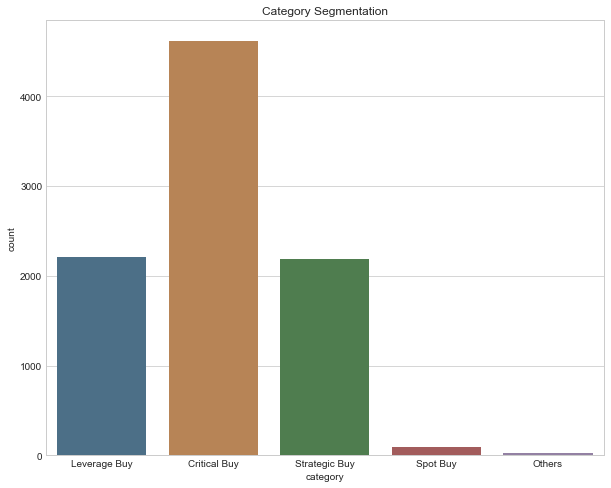

In [1356]:
#Count plot to see Sourcing breakdown based on assigned category scores:
plt.figure(figsize=(10,8))
sns.set_style(style='whitegrid')
sns.countplot(x= 'category', data = segmented, saturation=0.4)
plt.title('Category Segmentation')

In [1357]:
#Calculate % of each source type:
a= segmented['category'].value_counts()
b= segmented['category'].count()
c=a/b
print(c)

Critical Buy     0.504922
Leverage Buy     0.241851
Strategic Buy    0.239335
Spot Buy         0.010720
Others           0.003172
Name: category, dtype: float64


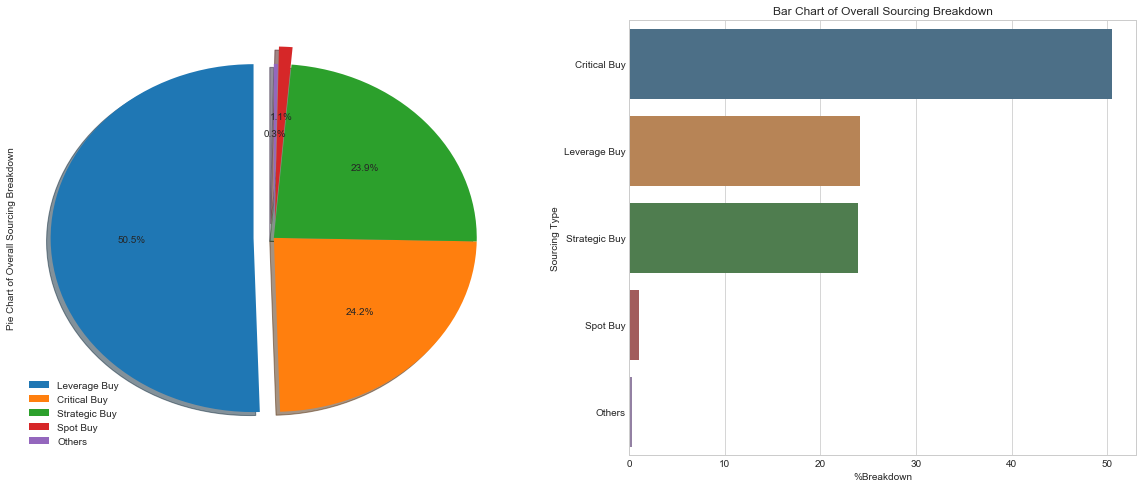

In [1358]:
#Plot pie and bar chart to see %breakdown of each sourcing type: 
plt.figure(figsize = (20,8))
plt.subplot(1,2,2)
sns.barplot(y = c.index, x = c * 100, saturation=0.4, label= 'Spend Breakdown')
plt.xlabel('%Breakdown')
plt.ylabel('Sourcing Type')
plt.title('Bar Chart of Overall Sourcing Breakdown')
plt.subplot(1,2,1)
c.plot(kind= 'pie', label='Pie Chart of Overall Sourcing Breakdown', explode= (0.1, 0, 0, 0.1,0), autopct='%1.1f%%', shadow=True, startangle=90, labels = None)
plt.legend(segmented['category'].unique(),loc='lower left')

### Observation: 
1. Majority of tube assemblies are purchased from sole suppliers, 50.5%
2. Leverage and Startegic Options account for 24% each. 
3. There may be opportities to consolodate critical spend with leverage or strategic suppliers. 

## B. Approach: Build Secondary Table by Concatenating Assembly Components 

In [1359]:
#load component tables and merge along seconday key component_id 
tables = ['components.csv',
          'comp_adaptor.csv',
          'comp_boss.csv', 
          'comp_elbow.csv',
          'comp_float.csv', 
          'comp_hfl.csv', 
          'comp_nut.csv', 
          'comp_other.csv', 
          'comp_sleeve.csv', 
          'comp_straight.csv', 
          'comp_tee.csv', 
          'comp_threaded.csv']

df_comps = [pd.read_csv(table) for table in tables]

#Concatenate Vertically:
df_comps_2 = pd.concat(df_comps, axis='rows')

#code idea from stackoverflow
#df_0_11= df_comps[0].join(df_comps[1:], on='component_id', how = 'left').....class type error
#df_comps= reduce(lambda left,right: pd.merge(left,right,on='component_id'), tables)

In [1360]:
#Re-set index to Component-id 
df_comps_2.set_index(['component_id', 'component_type_id', 'name']).head()

,,,adaptor_angle,base_diameter,base_type,blind_hole,bolt_pattern_long,bolt_pattern_wide,connection_type_id,connection_type_id_1,connection_type_id_2,connection_type_id_3,...,thread_pitch_3,thread_pitch_4,thread_size,thread_size_1,thread_size_2,thread_size_3,thread_size_4,type,unique_feature,weight
component_id,component_type_id,name,,,,,,,,,,,,,,,,,,,,,
9999,OTHER,OTHER,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
C-0001,CP-024,SLEEVE,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
C-0002,CP-024,SLEEVE,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
C-0003,CP-024,SLEEVE-FLARED,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
C-0004,CP-026,NUT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [1361]:
df_comps_2.columns

Index(['adaptor_angle', 'base_diameter', 'base_type', 'blind_hole',
       'bolt_pattern_long', 'bolt_pattern_wide', 'component_id',
       'component_type_id', 'connection_type_id', 'connection_type_id_1',
       'connection_type_id_2', 'connection_type_id_3', 'connection_type_id_4',
       'corresponding_shell', 'coupling_class', 'diameter', 'drop_length',
       'elbow_angle', 'end_form_id_1', 'end_form_id_2', 'end_form_id_3',
       'end_form_id_4', 'extension_length', 'groove', 'head_diameter',
       'height_over_tube', 'hex_nut_size', 'hex_size', 'hose_diameter',
       'intended_nut_pitch', 'intended_nut_thread', 'length', 'length_1',
       'length_2', 'length_3', 'length_4', 'material', 'mj_class_code',
       'mj_plug_class_code', 'name', 'nominal_size_1', 'nominal_size_2',
       'nominal_size_3', 'nominal_size_4', 'orientation', 'outside_shape',
       'overall_length', 'part_name', 'plating', 'plug_diameter', 'seat_angle',
       'shoulder_diameter', 'thickness', 'thread_

## Check and drop duplicate values after concatenation

In [1362]:
#Shape
df_comps_2.shape

(4095, 66)

In [1363]:
#drop duplicate
df_comps_2.drop_duplicates(inplace=True)

In [1364]:
#Check Shape
df_comps_2.shape

(4095, 66)

## Treat null values in the secondary table: 

In [1365]:
#checking for secondary columns with less than 77 percent of null data. 
#Similar to primary table where null columns between 31% to 76% had no impact on the overall data. 

columns_77= df_comps_2.isnull().sum()/df_comps_2.shape[0]* 100 < 77
columns_77.value_counts() #this means 59 columns under 77% of the null values have been dropped.

False    59
True      7
dtype: int64

In [1366]:
#View secondary table with less than 77% null values: 
df_secnd = df_comps_2.loc[:,columns_77]
df_secnd.head()

,component_id,component_type_id,name,orientation,part_name,unique_feature,weight
0,9999,OTHER,OTHER,NaN,NaN,NaN,NaN
1,C-0001,CP-024,SLEEVE,NaN,NaN,NaN,NaN
2,C-0002,CP-024,SLEEVE,NaN,NaN,NaN,NaN
3,C-0003,CP-024,SLEEVE-FLARED,NaN,NaN,NaN,NaN
4,C-0004,CP-026,NUT,NaN,NaN,NaN,NaN


In [1367]:
# View secondary table info
df_secnd.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4095 entries, 0 to 193
Data columns (total 7 columns):
component_id         4095 non-null object
component_type_id    3094 non-null object
name                 2047 non-null object
orientation          1046 non-null object
part_name            1001 non-null object
unique_feature       959 non-null object
weight               1976 non-null float64
dtypes: float64(1), object(6)
memory usage: 255.9+ KB


In [1368]:
#Convert data type from object to category:
#df_third[df_third.select_dtypes(['object']).columns] = df_third.select_dtypes(['object']).apply(lambda x: x.astype('category'))
df_secnd[df_secnd.select_dtypes(['object']).columns]=df_secnd.select_dtypes(['object']).apply(lambda x: x.astype('category'))

In [1369]:
df_secnd.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4095 entries, 0 to 193
Data columns (total 7 columns):
component_id         4095 non-null category
component_type_id    3094 non-null category
name                 2047 non-null category
orientation          1046 non-null category
part_name            1001 non-null category
unique_feature       959 non-null category
weight               1976 non-null float64
dtypes: category(6), float64(1)
memory usage: 221.6 KB


In [1370]:
# Count of null values in secondary table: 
df_secnd.isnull().sum()

component_id            0
component_type_id    1001
name                 2048
orientation          3049
part_name            3094
unique_feature       3136
weight               2119
dtype: int64

In [1371]:
#Checking component_id's that have both missing and non-missing values:
df_secnd.set_index('component_id').sort_index(ascending = True).head(20)

,component_type_id,name,orientation,part_name,unique_feature,weight
component_id,,,,,,
9999,OTHER,OTHER,NaN,NaN,NaN,NaN
C-0001,CP-024,SLEEVE,NaN,NaN,NaN,NaN
C-0001,CP-024,NaN,No,NaN,No,0.013
C-0002,CP-024,SLEEVE,NaN,NaN,NaN,NaN
C-0002,CP-024,NaN,No,NaN,No,0.005
C-0003,CP-024,SLEEVE-FLARED,NaN,NaN,NaN,NaN
C-0003,CP-024,NaN,No,NaN,No,0.014
C-0004,CP-026,NaN,No,NaN,NaN,0.014
C-0004,CP-026,NUT,NaN,NaN,NaN,NaN


### Identify Outliers in Weight: 

Text(0,0.5,'Weight Distribution Above 2')

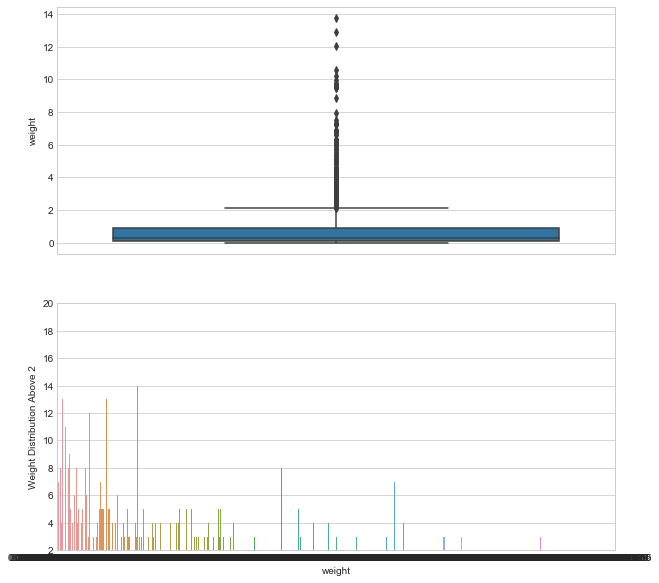

In [1372]:
#Outliers in weight: 
plt.figure(figsize=(10,10))
plt.subplot(2,1,1)
sns.boxplot(y = 'weight', data= df_secnd)

plt.subplot(2,1,2)

sns.countplot(x='weight', data = df_secnd)
#plt.xlim(xmin = 0, xmax= 20)
plt.ylim(ymin= 2, ymax= 20)
plt.ylabel('Weight Distribution Above 2')

##  Treating Missing Values in the secondary table: 

In [1373]:
#Since, multiple components with same reference number have both missing and non-missing values.
#We will assign missing values for common components using forward fill and backward fill method. 

In [1374]:
#Treat Missing Weight values: 
df_secnd['weight']=df_secnd.groupby(['component_id'])['weight'].transform(lambda x: x.fillna(method = 'bfill'))

# Treat Missing Unique_features:
df_secnd['unique_feature']=df_secnd.groupby(['component_id'])['unique_feature'].transform(lambda x: x.fillna(method = 'bfill'))

#Treat Missing Orientation vlaues:
df_secnd['orientation']=df_secnd.groupby(['component_id'])['orientation'].transform(lambda x: x.fillna(method = 'bfill'))

#Treat Description 
df_secnd[['component_type_id', 'name', 'part_name']]=df_secnd.groupby(['component_id'])['component_type_id', 'name', 'part_name'].transform(lambda x: x.fillna(method = 'ffill'))



#Optional: We could have filled median values for weight to avoid outliers. 
#Impute function to fill missing weights with median values 
#def impute_median(series):
    #return series.fillna(series.median())
#df_secnd = df_secnd['weight'].transform(impute_median)

### Treat other missing weight values 

In [1375]:
#Checking Missing Weight Values after bacward fill:
print('Null Weights after Backward Fill:', df_secnd['weight'].isnull().sum())

Null Weights after Backward Fill: 143


In [1376]:
#Write a function to fill null values with median weight values:
def impute_weight(series):
    
    """ 
       This function will fill null values 
       in the series with its median.

    """  
    return series.fillna(series.median())

df_secnd['weight']= df_secnd['weight'].transform(impute_weight)

#Re-Check for null weight values: 
print('Null Weights after Impute Weight:', df_secnd['weight'].isnull().sum())
df_secnd['weight'].describe()

Null Weights after Impute Weight: 0


count    4095.000000
mean        0.756992
std         1.348655
min         0.001000
25%         0.086500
50%         0.263500
75%         0.843000
max        13.770000
Name: weight, dtype: float64

### Visualize Weight Distribution 

Text(0.5,1,'Overall Weight Ditribution')

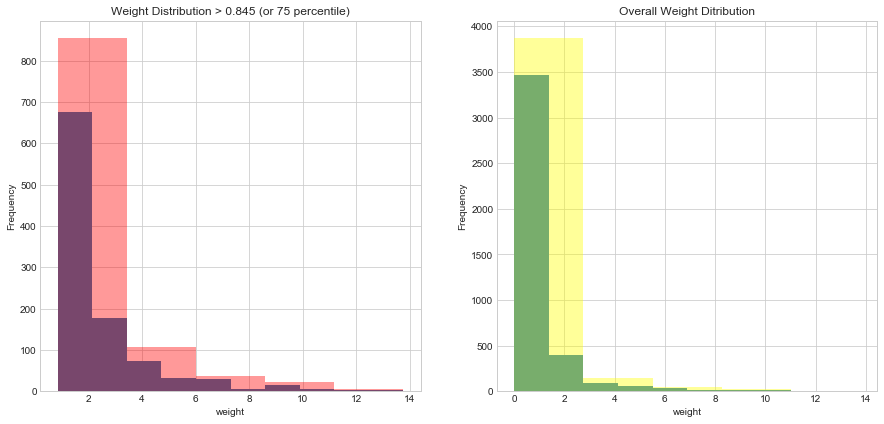

In [1377]:
# Count weight values > 75% quartile range:
plt.figure(figsize=(15,15))
plt.subplot(2,2,1)
df_secnd['weight'][df_secnd['weight'] > 0.843].plot(kind='hist')
sns.distplot(df_secnd['weight'][df_secnd['weight'] > 0.843], bins=5, kde= False, color = 'red' )
plt.title('Weight Distribution > 0.845 (or 75 percentile)')
plt.subplot(2,2,2)
df_secnd['weight'].plot(kind='hist')
sns.distplot(df_secnd['weight'], bins=5, kde= False, color= 'yellow')
plt.title('Overall Weight Ditribution')

In [1378]:
# Most Component Names: 
print('Weight Range between 2 & 4:','\n',df_secnd['name'][(df_secnd['weight'] >=2) & (df_secnd['weight'] <=4)].value_counts().head())
print('Weight Range between 4 & 8:','\n',df_secnd['name'][(df_secnd['weight'] >4) & (df_secnd['weight'] <=8)].value_counts().head())
print('Weight Range between 8 & 14:','\n',df_secnd['name'][(df_secnd['weight'] >8) & (df_secnd['weight'] <=14)].value_counts().head())

Weight Range between 2 & 4: 
 FLANGE             78
ELBOW-HYDRAULIC    28
TUBE               24
ELBOW              18
FLANGE-ONE PIEC    18
Name: name, dtype: int64
Weight Range between 4 & 8: 
 TUBE               30
FLANGE             28
BLOCK              16
ELBOW-HYDRAULIC    16
TUBE AS             6
Name: name, dtype: int64
Weight Range between 8 & 14: 
 ELBOW-HYDRAULIC    6
FLANGE             4
ELBOW-BRAZE        4
TUBE               4
ELBOW              4
Name: name, dtype: int64


### Observation: 
1. Highest count of weight distribution outside of 75% quartile range is between 2 and 3.
2. Most common and heavy weight items in the distribution are Flanges, Elbow-Hydraulics and Tubes
3. Majority of component weights is between 0 and 2. 

In [1379]:
#View Treated Secondary Table:
df_secnd_trt= df_secnd.set_index('component_id').sort_index()
df_secnd_trt=df_secnd_trt.reset_index()
df_secnd_trt.head()

,component_id,component_type_id,name,orientation,part_name,unique_feature,weight
0,9999,OTHER,OTHER,NaN,NaN,NaN,0.2635
1,C-0001,CP-024,SLEEVE,No,NaN,No,0.0130
2,C-0001,CP-024,SLEEVE,No,NaN,No,0.0130
3,C-0002,CP-024,SLEEVE,No,NaN,No,0.0050
4,C-0002,CP-024,SLEEVE,No,NaN,No,0.0050


In [1380]:
#Delete first row containing invalid component ID: 9999:
df_secnd_trt=df_secnd_trt.drop(df_secnd_trt.index[0])

#View Treated Secondary Table
df_secnd_trt.head()

,component_id,component_type_id,name,orientation,part_name,unique_feature,weight
1,C-0001,CP-024,SLEEVE,No,NaN,No,0.013
2,C-0001,CP-024,SLEEVE,No,NaN,No,0.013
3,C-0002,CP-024,SLEEVE,No,NaN,No,0.005
4,C-0002,CP-024,SLEEVE,No,NaN,No,0.005
5,C-0003,CP-024,SLEEVE-FLARED,No,NaN,No,0.014


## Prepare Final Table for Modelling:
### a) Supplier Price prediction 

### 1.Merge Primary, Secondary and Tube End Form Table: 

In [1381]:
#Rename compenent_id lable in secondary table so that we can merge  
df_secnd_trt= df_secnd_trt.rename(columns= {'component_id': 'component_id_a'})
#df_secnd_trt['component_id_b']= df_secnd_trt['component_id_a'].copy()
df_secnd_trt.head() 

,component_id_a,component_type_id,name,orientation,part_name,unique_feature,weight
1,C-0001,CP-024,SLEEVE,No,NaN,No,0.013
2,C-0001,CP-024,SLEEVE,No,NaN,No,0.013
3,C-0002,CP-024,SLEEVE,No,NaN,No,0.005
4,C-0002,CP-024,SLEEVE,No,NaN,No,0.005
5,C-0003,CP-024,SLEEVE-FLARED,No,NaN,No,0.014


In [1382]:
#Rename end_form_id in tube_end_form table so thta we can merge with the final table:
df_end_form=df_end_form.rename(columns={'end_form_id': 'end_a1'})

In [1383]:
#Merge primary table component_id_1 with secondary table component_id_a
df_merge1=pd.merge(left = df_prime, right = df_secnd_trt, left_on= ['component_id_1'], right_on=['component_id_a'], how ='left')

#Merge end_a from df_merge1 with end_a1 to capture forming_end_a 
df_final1= pd.merge(left= df_merge1, right= df_end_form, left_on = ['end_a'], right_on= ['end_a1'], how = 'left')
df_final1=df_final1.rename(columns={'forming': 'forming_end_a'}).drop('end_a1', axis=1)

#Merge end_x from df_final1 with end_a1 to capture forming_end_x 
df_final2= pd.merge(left= df_final1, right= df_end_form, left_on = ['end_x'], right_on= ['end_a1'], how = 'left')
df_final2=df_final2.rename(columns={'forming': 'forming_end_x'}).drop('end_a1', axis=1)

#View first final table 'df_final2' contaning common components_id_1, forming end_a and forming end_x: 
df_final2.head()

,tube_assembly_id,supplier,bracket_pricing,component_id_1,quantity_1,component_id_2,quantity_2,material_id,diameter,wall,...,total_cost,component_id_a,component_type_id,name,orientation,part_name,unique_feature,weight,forming_end_a,forming_end_x
0,TA-00002,S-0066,Yes,C-1312,2.0,NaN,NaN,SP-0019,6.35,0.71,...,0.0,C-1312,CP-028,NUT-FLARED,No,NaN,No,0.009,Yes,Yes
1,TA-00002,S-0066,Yes,C-1312,2.0,NaN,NaN,SP-0019,6.35,0.71,...,0.0,C-1312,CP-028,NUT-FLARED,No,NaN,No,0.009,Yes,Yes
2,TA-00002,S-0066,Yes,C-1312,2.0,NaN,NaN,SP-0019,6.35,0.71,...,0.0,C-1312,CP-028,NUT-FLARED,No,NaN,No,0.009,Yes,Yes
3,TA-00002,S-0066,Yes,C-1312,2.0,NaN,NaN,SP-0019,6.35,0.71,...,0.0,C-1312,CP-028,NUT-FLARED,No,NaN,No,0.009,Yes,Yes
4,TA-00002,S-0066,Yes,C-1312,2.0,NaN,NaN,SP-0019,6.35,0.71,...,0.0,C-1312,CP-028,NUT-FLARED,No,NaN,No,0.009,Yes,Yes


In [1384]:
#Merge primary table component_id_2 with secondary table component_id renamed as component_id_b
df_merge2 = pd.merge(left = df_prime, right = df_secnd_trt, left_on= ['component_id_2'], right_on=['component_id_a'], how ='left')
df_merge2=df_merge2.rename(columns={'component_id_a': 'component_id_b'})

#Merge end_a from df_merge2 with end_a1 to capture forming_end_a 
df_final3= pd.merge(left= df_merge2, right= df_end_form, left_on = ['end_a'], right_on= ['end_a1'], how = 'left')
df_final3=df_final3.rename(columns={'forming': 'forming_end_a'}).drop('end_a1', axis=1)

#Merge end_x from df_final3 with end_a1 to capture forming_end_x 
df_final4= pd.merge(left= df_final3, right= df_end_form, left_on = ['end_x'], right_on= ['end_a1'], how = 'left')
df_final4=df_final4.rename(columns={'forming': 'forming_end_x'}).drop('end_a1', axis=1)

#View Second final table 'df_final4' contaning common components_id_2, forming end_a and forming end_x: 
df_final4.head()

,tube_assembly_id,supplier,bracket_pricing,component_id_1,quantity_1,component_id_2,quantity_2,material_id,diameter,wall,...,total_cost,component_id_b,component_type_id,name,orientation,part_name,unique_feature,weight,forming_end_a,forming_end_x
0,TA-00002,S-0066,Yes,C-1312,2.0,NaN,NaN,SP-0019,6.35,0.71,...,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Yes,Yes
1,TA-00002,S-0066,Yes,C-1312,2.0,NaN,NaN,SP-0019,6.35,0.71,...,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Yes,Yes
2,TA-00002,S-0066,Yes,C-1312,2.0,NaN,NaN,SP-0019,6.35,0.71,...,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Yes,Yes
3,TA-00002,S-0066,Yes,C-1312,2.0,NaN,NaN,SP-0019,6.35,0.71,...,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Yes,Yes
4,TA-00002,S-0066,Yes,C-1312,2.0,NaN,NaN,SP-0019,6.35,0.71,...,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Yes,Yes


### Testing for common component between component_id_1 and component_id_2

In [1385]:
#Checking for common components_id's in the tube assembly  
matched=[]
for i in df_prime['component_id_1']:
    for j in df_prime['component_id_2']:
        if i == j:
            print(matched.append(df_prime['component_id_2']))
    break

None
None
None
None
None
None
None
None
None


### Observation: 
1. There are no common component parts between component_id_1 and component_id_2.

## Continue building the final table: 

In [1386]:
#Concatenate df_final2 and df_final4 tables: 
df_final = pd.concat([df_final2, df_final4], axis = 'rows')
df_final.shape

(110261, 41)

In [1387]:
# Drop Duplicates fron the final table: 
df_final = df_final.drop_duplicates()
df_final.shape

(60682, 41)

In [1388]:
#Describe final table: 
df_final.describe(include='all')#.iloc[:,10:30]

,%sequential_rebate,%unit_rebate,annual_usage,bend_radius,bracket_pricing,component_id_1,component_id_2,component_id_a,component_id_b,component_type_id,...,quantity,quantity_1,quantity_2,quote_date,supplier,total_cost,tube_assembly_id,unique_feature,wall,weight
count,60682.000000,60682.000000,60682.000000,60682.000000,60682,59220,43383,29812,21741,51553,...,60682.000000,59220.000000,43383.000000,60682,60682,60682.000000,60682,28690,60682.000000,51553.000000
unique,NaN,NaN,NaN,NaN,2,642,452,642,452,26,...,NaN,NaN,NaN,1781,57,NaN,8855,2,NaN,NaN
top,NaN,NaN,NaN,NaN,Yes,C-1621,C-1628,C-1621,C-1628,CP-024,...,NaN,NaN,NaN,2013-10-01 00:00:00,S-0066,NaN,TA-02366,Yes,NaN,NaN
freq,NaN,NaN,NaN,NaN,52678,7784,7510,3892,3755,18175,...,NaN,NaN,NaN,5738,40886,NaN,32,14785,NaN,NaN
first,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,1982-09-22 00:00:00,NaN,NaN,NaN,NaN,NaN,NaN
last,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,2017-01-01 00:00:00,NaN,NaN,NaN,NaN,NaN,NaN
mean,17.865313,48.940775,124.251277,41.493947,NaN,NaN,NaN,NaN,NaN,NaN,...,38.754194,1.632489,1.561141,NaN,NaN,439.677855,NaN,NaN,1.384355,0.080390
std,21.211605,35.980303,1616.166705,195.699872,NaN,NaN,NaN,NaN,NaN,NaN,...,70.694593,0.492527,0.507143,NaN,NaN,6588.366372,NaN,NaN,0.633740,0.371172
min,0.000000,0.000000,0.000000,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,...,1.000000,1.000000,1.000000,NaN,NaN,0.000000,NaN,NaN,0.710000,0.001000
25%,0.000000,0.000000,0.000000,19.050000,NaN,NaN,NaN,NaN,NaN,NaN,...,2.000000,1.000000,1.000000,NaN,NaN,0.000000,NaN,NaN,0.890000,0.009000


### Identify Outliers in Bend_Radius:

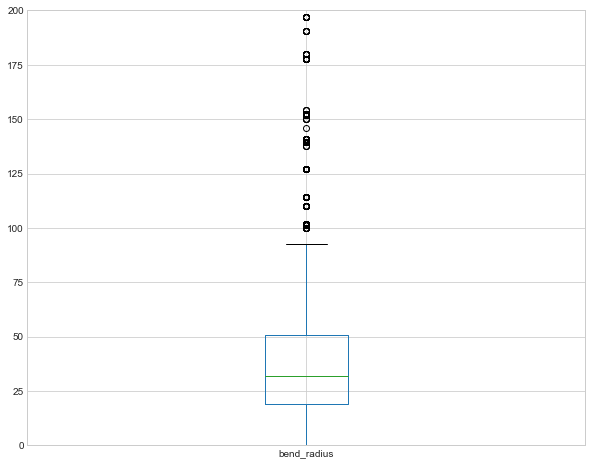

In [1389]:
#Explore bend radius for outliers:
plt.figure(figsize= (10,8))
df_final['bend_radius'].plot(kind= 'box', ylim= (0, 200))

### Treat Outliers in Bend_Radius

In [1390]:
#Calculate Inter Quartile Range: 
q1= df_final['bend_radius'].quantile(0.25)
q2 = df_final['bend_radius'].quantile(0.75)
iqr = q2-q1
iqr

31.749999999999996

In [1391]:
#Replace outliers in bend_radius > 75% with Inter Quartile Range: 
df_final['bend_radius'][df_final['bend_radius']>50.8]=(df_final['bend_radius'][df_final['bend_radius']>50.8]).replace(to_replace=df_final['bend_radius'][df_final['bend_radius']>50.8], value= 31.75)

In [1392]:
#View Final Table: 
df_final.head()

,%sequential_rebate,%unit_rebate,annual_usage,bend_radius,bracket_pricing,component_id_1,component_id_2,component_id_a,component_id_b,component_type_id,...,quantity,quantity_1,quantity_2,quote_date,supplier,total_cost,tube_assembly_id,unique_feature,wall,weight
0,0.000000,0.000000,0,19.05,Yes,C-1312,NaN,C-1312,NaN,CP-028,...,1,2.0,NaN,2013-07-07,S-0066,0.0,TA-00002,No,0.71,0.009
2,43.662687,43.662687,0,19.05,Yes,C-1312,NaN,C-1312,NaN,CP-028,...,2,2.0,NaN,2013-07-07,S-0066,0.0,TA-00002,No,0.71,0.009
4,46.505861,69.862840,0,19.05,Yes,C-1312,NaN,C-1312,NaN,CP-028,...,5,2.0,NaN,2013-07-07,S-0066,0.0,TA-00002,No,0.71,0.009
6,28.992836,78.600457,0,19.05,Yes,C-1312,NaN,C-1312,NaN,CP-028,...,10,2.0,NaN,2013-07-07,S-0066,0.0,TA-00002,No,0.71,0.009
8,24.451039,83.832868,0,19.05,Yes,C-1312,NaN,C-1312,NaN,CP-028,...,25,2.0,NaN,2013-07-07,S-0066,0.0,TA-00002,No,0.71,0.009


In [1393]:
#sns.jointplot(x= 'weight', y = 'cost', data = df_final, kind= 'kde')

In [1394]:
#df_final[df_final['bend_radius']>0.036].iloc[:, 0:41]

In [1395]:
# Breakdown of null values resulting due to merge between primary, secondary and tube end form tables.
df_final[['component_id_1', 'component_id_a', 'component_id_2', 'component_id_b', 'forming_end_a', 'forming_end_x']].isnull().sum() / 60682 * 100

component_id_1     2.409281
component_id_a    50.871758
component_id_2    28.507630
component_id_b    64.172242
forming_end_a      2.623513
forming_end_x      3.988003
dtype: float64

### Observation: 
1. Tube assembly made up of component id_1 comes with 50% attached components and 50% non-attached components
2. Tube assembly made up of component id_2 comes with 36% attached components and 64% non-attached components
3. Tube assembly end_a and end_x comes with formed and non-formed ends.   
4. The cost of tube assembly should vary with features 1,2,3 above, which we intend to see in the model later. 

In [1396]:
#View final merged table
df_final.iloc[:,0:50].head()

,%sequential_rebate,%unit_rebate,annual_usage,bend_radius,bracket_pricing,component_id_1,component_id_2,component_id_a,component_id_b,component_type_id,...,quantity,quantity_1,quantity_2,quote_date,supplier,total_cost,tube_assembly_id,unique_feature,wall,weight
0,0.000000,0.000000,0,19.05,Yes,C-1312,NaN,C-1312,NaN,CP-028,...,1,2.0,NaN,2013-07-07,S-0066,0.0,TA-00002,No,0.71,0.009
2,43.662687,43.662687,0,19.05,Yes,C-1312,NaN,C-1312,NaN,CP-028,...,2,2.0,NaN,2013-07-07,S-0066,0.0,TA-00002,No,0.71,0.009
4,46.505861,69.862840,0,19.05,Yes,C-1312,NaN,C-1312,NaN,CP-028,...,5,2.0,NaN,2013-07-07,S-0066,0.0,TA-00002,No,0.71,0.009
6,28.992836,78.600457,0,19.05,Yes,C-1312,NaN,C-1312,NaN,CP-028,...,10,2.0,NaN,2013-07-07,S-0066,0.0,TA-00002,No,0.71,0.009
8,24.451039,83.832868,0,19.05,Yes,C-1312,NaN,C-1312,NaN,CP-028,...,25,2.0,NaN,2013-07-07,S-0066,0.0,TA-00002,No,0.71,0.009


In [1397]:
# View final table columns 
df_final.columns

Index(['%sequential_rebate', '%unit_rebate', 'annual_usage', 'bend_radius',
       'bracket_pricing', 'component_id_1', 'component_id_2', 'component_id_a',
       'component_id_b', 'component_type_id', 'cost', 'diameter', 'end_a',
       'end_a_1x', 'end_a_2x', 'end_x', 'end_x_1x', 'end_x_2x',
       'extended_cost', 'forming_end_a', 'forming_end_x', 'length',
       'material_id', 'min_order_quantity', 'name', 'num_bends', 'num_boss',
       'num_bracket', 'orientation', 'other', 'part_name', 'quantity',
       'quantity_1', 'quantity_2', 'quote_date', 'supplier', 'total_cost',
       'tube_assembly_id', 'unique_feature', 'wall', 'weight'],
      dtype='object')

In [1398]:
#Re-arrange column positions inside the table:
df_final= df_final.reindex_axis(labels=['tube_assembly_id', 'supplier', 'bracket_pricing', 'material_id','component_type_id',
       'component_id_1','component_id_a', 'quantity_1', 'component_id_2', 'component_id_b', 'quantity_2', 
       'diameter','wall', 'length', 'num_bends', 'bend_radius', 'end_a_1x', 'end_a_2x','forming_end_x',
       'end_x_1x', 'end_x_2x', 'end_a', 'forming_end_a', 'end_x', 'num_boss', 'num_bracket',
       'other','name','orientation', 'part_name', 'unique_feature', 'weight','quote_date', 'annual_usage', 'min_order_quantity', 'quantity',
       '%sequential_rebate', '%unit_rebate', 'extended_cost','total_cost','cost'], axis=1)

In [1399]:
#Check final table shape to ensure same content:
df_final.shape

(60682, 41)

In [1400]:
#View final re-arranged table: 
df_final.head()

,tube_assembly_id,supplier,bracket_pricing,material_id,component_type_id,component_id_1,component_id_a,quantity_1,component_id_2,component_id_b,...,weight,quote_date,annual_usage,min_order_quantity,quantity,%sequential_rebate,%unit_rebate,extended_cost,total_cost,cost
0,TA-00002,S-0066,Yes,SP-0019,CP-028,C-1312,C-1312,2.0,NaN,NaN,...,0.009,2013-07-07,0,0,1,0.000000,0.000000,21.905933,0.0,21.905933
2,TA-00002,S-0066,Yes,SP-0019,CP-028,C-1312,C-1312,2.0,NaN,NaN,...,0.009,2013-07-07,0,0,2,43.662687,43.662687,24.682428,0.0,12.341214
4,TA-00002,S-0066,Yes,SP-0019,CP-028,C-1312,C-1312,2.0,NaN,NaN,...,0.009,2013-07-07,0,0,5,46.505861,69.862840,33.009131,0.0,6.601826
6,TA-00002,S-0066,Yes,SP-0019,CP-028,C-1312,C-1312,2.0,NaN,NaN,...,0.009,2013-07-07,0,0,10,28.992836,78.600457,46.877695,0.0,4.687770
8,TA-00002,S-0066,Yes,SP-0019,CP-028,C-1312,C-1312,2.0,NaN,NaN,...,0.009,2013-07-07,0,0,25,24.451039,83.832868,88.539030,0.0,3.541561


In [1401]:
df_final.to_csv('predict.csv')

In [1402]:
df_final.columns

Index(['tube_assembly_id', 'supplier', 'bracket_pricing', 'material_id',
       'component_type_id', 'component_id_1', 'component_id_a', 'quantity_1',
       'component_id_2', 'component_id_b', 'quantity_2', 'diameter', 'wall',
       'length', 'num_bends', 'bend_radius', 'end_a_1x', 'end_a_2x',
       'forming_end_x', 'end_x_1x', 'end_x_2x', 'end_a', 'forming_end_a',
       'end_x', 'num_boss', 'num_bracket', 'other', 'name', 'orientation',
       'part_name', 'unique_feature', 'weight', 'quote_date', 'annual_usage',
       'min_order_quantity', 'quantity', '%sequential_rebate', '%unit_rebate',
       'extended_cost', 'total_cost', 'cost'],
      dtype='object')

### 2. Transform Categorical Columns in the Final Table in to Dummy Variables: 

In [1403]:
#Import Lable Encoder
from sklearn.preprocessing import LabelEncoder

### Option1: Appying Label Encoder without One hot Encoding:

In [1404]:
#Store Categorical Columns in Col: 
col=df_final[['bracket_pricing','component_id_1', 'component_id_2','component_id_a', 'component_id_b', 'supplier', 'material_id', 'end_a', 'end_x', 'end_a_1x', 'end_a_2x', 'end_x_1x', 'end_x_2x', 'orientation', 'unique_feature', 'forming_end_a', 'forming_end_x']]

In [1405]:
#Give new lables to Categorical columns in df_final table: 
df_final_label = col.astype(str).apply(LabelEncoder().fit_transform) 

#View Lables
df_final_label.head()

,bracket_pricing,component_id_1,component_id_2,component_id_a,component_id_b,supplier,material_id,end_a,end_x,end_a_1x,end_a_2x,end_x_1x,end_x_2x,orientation,unique_feature,forming_end_a,forming_end_x
0,1,348,452,348,452,36,1,7,8,0,0,0,0,0,0,1,1
2,1,348,452,348,452,36,1,7,8,0,0,0,0,0,0,1,1
4,1,348,452,348,452,36,1,7,8,0,0,0,0,0,0,1,1
6,1,348,452,348,452,36,1,7,8,0,0,0,0,0,0,1,1
8,1,348,452,348,452,36,1,7,8,0,0,0,0,0,0,1,1


In [1406]:
#Drop initial category columns from the df_final table to avoid duplication:
df_final_drop=df_final.drop(columns = ['bracket_pricing','component_id_1', 'component_id_2','component_id_a', 'component_id_b', 'supplier', 'material_id', 'end_a', 'end_x', 'end_a_1x', 'end_a_2x', 'end_x_1x', 'end_x_2x', 'orientation', 'unique_feature', 'forming_end_a', 'forming_end_x'], axis = 1)

In [1407]:
#Concatenate converted category columns with df_final_dropped: 
df_final_1 = pd.concat([df_final_drop, df_final_label], axis = 1)

In [1408]:
#Shape of final table 1:
df_final_1.shape

(60682, 41)

In [1409]:
#View final table from option 1 for modelling: 
df_final_1.head()

,tube_assembly_id,component_type_id,quantity_1,quantity_2,diameter,wall,length,num_bends,bend_radius,num_boss,...,end_a,end_x,end_a_1x,end_a_2x,end_x_1x,end_x_2x,orientation,unique_feature,forming_end_a,forming_end_x
0,TA-00002,CP-028,2.0,NaN,6.35,0.71,137.0,8,19.05,0,...,7,8,0,0,0,0,0,0,1,1
2,TA-00002,CP-028,2.0,NaN,6.35,0.71,137.0,8,19.05,0,...,7,8,0,0,0,0,0,0,1,1
4,TA-00002,CP-028,2.0,NaN,6.35,0.71,137.0,8,19.05,0,...,7,8,0,0,0,0,0,0,1,1
6,TA-00002,CP-028,2.0,NaN,6.35,0.71,137.0,8,19.05,0,...,7,8,0,0,0,0,0,0,1,1
8,TA-00002,CP-028,2.0,NaN,6.35,0.71,137.0,8,19.05,0,...,7,8,0,0,0,0,0,0,1,1


### Option2: Convert Dummy Variables using One Hot Encoding and apply Label Encoder: 

In [1410]:
#Get Dummy variables for Categorical Columns:
df_dummy= pd.get_dummies(df_final[['bracket_pricing','component_id_1', 'component_id_2','component_id_a', 'component_id_b', 'supplier', 'material_id', 'end_a', 'end_x', 'end_a_1x', 'end_a_2x', 'end_x_1x', 'end_x_2x', 'orientation', 'unique_feature', 'forming_end_a', 'forming_end_x']], drop_first = True)

#Apply Label Encoder:
df_dummy = df_dummy.apply(LabelEncoder().fit_transform)

# Concat dummy variables and drop original categorical columns:
df_final_2 = pd.concat([df_final, df_dummy], axis = 1).drop(columns = ['bracket_pricing','component_id_1', 'component_id_2','component_id_a', 'component_id_b', 'supplier', 'material_id', 'end_a', 'end_x', 'end_a_1x', 'end_a_2x', 'end_x_1x', 'end_x_2x', 'orientation', 'unique_feature', 'forming_end_a', 'forming_end_x'], axis = 1)

In [1411]:
#View final table 2: 
df_final_2.head()

,tube_assembly_id,component_type_id,quantity_1,quantity_2,diameter,wall,length,num_bends,bend_radius,num_boss,...,end_x_EF-023,end_x_NONE,end_a_1x_Y,end_a_2x_Y,end_x_1x_Y,end_x_2x_Y,orientation_Yes,unique_feature_Yes,forming_end_a_Yes,forming_end_x_Yes
0,TA-00002,CP-028,2.0,NaN,6.35,0.71,137.0,8,19.05,0,...,0,0,0,0,0,0,0,0,1,1
2,TA-00002,CP-028,2.0,NaN,6.35,0.71,137.0,8,19.05,0,...,0,0,0,0,0,0,0,0,1,1
4,TA-00002,CP-028,2.0,NaN,6.35,0.71,137.0,8,19.05,0,...,0,0,0,0,0,0,0,0,1,1
6,TA-00002,CP-028,2.0,NaN,6.35,0.71,137.0,8,19.05,0,...,0,0,0,0,0,0,0,0,1,1
8,TA-00002,CP-028,2.0,NaN,6.35,0.71,137.0,8,19.05,0,...,0,0,0,0,0,0,0,0,1,1


In [1412]:
#View shape of final table 2: 
df_final_2.shape

(60682, 2336)

### Observation: 
1. Option1: By applying label encoder only, the shape of the final table df_final_1 has 41 columns
2. Option2: By applying one hot encoder with lable encoder, the shape of the final table df_final_2 has 2,336 columns. 
3. Due to significant increase in the columns after applying one hot encoding, we have decided to build 2 models and see which option results in better model accuracy (option1 or option2). 

In [1413]:
#View Sample Assembly TA-00002 for option 1: 

In [1414]:
df_final_TA_00002=df_final_1[df_final_1['tube_assembly_id']=='TA-00002']
df_final_TA_00002.head()

,tube_assembly_id,component_type_id,quantity_1,quantity_2,diameter,wall,length,num_bends,bend_radius,num_boss,...,end_a,end_x,end_a_1x,end_a_2x,end_x_1x,end_x_2x,orientation,unique_feature,forming_end_a,forming_end_x
0,TA-00002,CP-028,2.0,NaN,6.35,0.71,137.0,8,19.05,0,...,7,8,0,0,0,0,0,0,1,1
2,TA-00002,CP-028,2.0,NaN,6.35,0.71,137.0,8,19.05,0,...,7,8,0,0,0,0,0,0,1,1
4,TA-00002,CP-028,2.0,NaN,6.35,0.71,137.0,8,19.05,0,...,7,8,0,0,0,0,0,0,1,1
6,TA-00002,CP-028,2.0,NaN,6.35,0.71,137.0,8,19.05,0,...,7,8,0,0,0,0,0,0,1,1
8,TA-00002,CP-028,2.0,NaN,6.35,0.71,137.0,8,19.05,0,...,7,8,0,0,0,0,0,0,1,1


### Model A: Prepare final table 1 for modelling: 

In [1415]:
#Replace missing values with 0
df_final_1.isnull().sum()
#Weight was previously treated for null values

tube_assembly_id          0
component_type_id      9129
quantity_1             1462
quantity_2            17299
diameter                  0
wall                      0
length                    0
num_bends                 0
bend_radius               0
num_boss                  0
num_bracket               0
other                     0
name                   9129
part_name             58964
weight                 9129
quote_date                0
annual_usage              0
min_order_quantity        0
quantity                  0
%sequential_rebate        0
%unit_rebate              0
extended_cost             0
total_cost                0
cost                      0
bracket_pricing           0
component_id_1            0
component_id_2            0
component_id_a            0
component_id_b            0
supplier                  0
material_id               0
end_a                     0
end_x                     0
end_a_1x                  0
end_a_2x                  0
end_x_1x            

In [1416]:
#Replave null values in quantity by 0
df_final_1[['quantity_1', 'quantity_2']]=df_final_1[['quantity_1', 'quantity_2']].fillna(0)

### Investigate null values in weight column, as it was already treated earlier??

In [1417]:
#Identify null values in weight. Investigate why null values in weight as it was already treated. 
df_final_1[['tube_assembly_id','weight']].isnull().sum()

tube_assembly_id       0
weight              9129
dtype: int64

In [1418]:
#Selecting tube assembly and various components to review assembly combinations: 
df_wt_null=df_final_1[['tube_assembly_id','bracket_pricing','component_id_1', 'component_id_2','component_id_a', 'component_id_b', 'supplier', 'material_id', 'end_a', 'end_x', 'end_a_1x', 'end_a_2x', 'end_x_1x', 'end_x_2x', 'orientation', 'unique_feature', 'forming_end_a', 'forming_end_x','cost','weight']].sort_values('weight')

#View Tube assembly example TA-21069:
df_wt_null[df_wt_null['tube_assembly_id']== 'TA-21069']

,tube_assembly_id,bracket_pricing,component_id_1,component_id_2,component_id_a,component_id_b,supplier,material_id,end_a,end_x,end_a_1x,end_a_2x,end_x_1x,end_x_2x,orientation,unique_feature,forming_end_a,forming_end_x,cost,weight
58729,TA-21069,1,412,452,412,452,36,3,22,22,0,0,0,0,1,0,0,0,30.744535,0.475
58739,TA-21069,1,412,452,412,452,36,3,22,22,0,0,0,0,1,0,0,0,10.838902,0.475
58741,TA-21069,1,412,452,412,452,36,3,22,22,0,0,0,0,1,0,0,0,10.683107,0.475
58743,TA-21069,1,412,452,412,452,36,3,22,22,0,0,0,0,1,0,0,0,10.591299,0.475
58733,TA-21069,1,412,452,412,452,36,3,22,22,0,0,0,0,1,0,0,0,14.438887,0.475
58731,TA-21069,1,412,452,412,452,36,3,22,22,0,0,0,0,1,0,0,0,20.553852,0.475
58737,TA-21069,1,412,452,412,452,36,3,22,22,0,0,0,0,1,0,0,0,11.178313,0.475
58735,TA-21069,1,412,452,412,452,36,3,22,22,0,0,0,0,1,0,0,0,12.402419,0.475
51099,TA-21069,1,412,452,642,452,36,3,22,22,0,0,0,0,2,2,0,0,30.744535,NaN
51100,TA-21069,1,412,452,642,452,36,3,22,22,0,0,0,0,2,2,0,0,20.553852,NaN


### Observation: 
1. Additional Null Values in Weight is due to different combinations of assemblies components for which weights were not given as shown above in example TA-21069. 
2. We will use impute_weight function once again to fill missing weight values. 

### Use 'impute_weight' function to replace missing weight values with median: 

In [1419]:
#Applying impute_weight Function: 
df_final_1['weight'] = df_final_1['weight'].transform(impute_weight)
print('Number of Missing Weight Values in the final table:', df_final_1['weight'].isnull().sum())

Number of Missing Weight Values in the final table: 0


In [1420]:
#Check for duplicates: 
print(df_final_1.shape)
print(df_final_1.drop_duplicates().shape)

(60682, 41)
(60682, 41)


In [1421]:
#View final table 1:
df_final_1.head()

,tube_assembly_id,component_type_id,quantity_1,quantity_2,diameter,wall,length,num_bends,bend_radius,num_boss,...,end_a,end_x,end_a_1x,end_a_2x,end_x_1x,end_x_2x,orientation,unique_feature,forming_end_a,forming_end_x
0,TA-00002,CP-028,2.0,0.0,6.35,0.71,137.0,8,19.05,0,...,7,8,0,0,0,0,0,0,1,1
2,TA-00002,CP-028,2.0,0.0,6.35,0.71,137.0,8,19.05,0,...,7,8,0,0,0,0,0,0,1,1
4,TA-00002,CP-028,2.0,0.0,6.35,0.71,137.0,8,19.05,0,...,7,8,0,0,0,0,0,0,1,1
6,TA-00002,CP-028,2.0,0.0,6.35,0.71,137.0,8,19.05,0,...,7,8,0,0,0,0,0,0,1,1
8,TA-00002,CP-028,2.0,0.0,6.35,0.71,137.0,8,19.05,0,...,7,8,0,0,0,0,0,0,1,1


In [1422]:
# View final table 1 data type: 
df_final_1.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 60682 entries, 0 to 51296
Data columns (total 41 columns):
tube_assembly_id      60682 non-null category
component_type_id     51553 non-null category
quantity_1            60682 non-null float64
quantity_2            60682 non-null float64
diameter              60682 non-null float64
wall                  60682 non-null float64
length                60682 non-null float64
num_bends             60682 non-null int64
bend_radius           60682 non-null float64
num_boss              60682 non-null int64
num_bracket           60682 non-null int64
other                 60682 non-null int64
name                  51553 non-null category
part_name             1718 non-null category
weight                60682 non-null float64
quote_date            60682 non-null datetime64[ns]
annual_usage          60682 non-null int64
min_order_quantity    60682 non-null int64
quantity              60682 non-null int64
%sequential_rebate    60682 non-null flo

In [1423]:
'''
#Convert tube_assembly_id datatupe from category to integer value: 
df_final_1['tube_assembly_id']=df_final_1['tube_assembly_id'].str.split('-').str.get(1)
df_final_1['tube_assembly_id']= pd.to_numeric(df_final_1['tube_assembly_id']).astype(np.int64)
df_final_1['tube_assembly_id'].dtype
'''

"\n#Convert tube_assembly_id datatupe from category to integer value: \ndf_final_1['tube_assembly_id']=df_final_1['tube_assembly_id'].str.split('-').str.get(1)\ndf_final_1['tube_assembly_id']= pd.to_numeric(df_final_1['tube_assembly_id']).astype(np.int64)\ndf_final_1['tube_assembly_id'].dtype\n"

In [1424]:
#Drop categorical columns from df_final_1 and stre df_model for modelling: 
df_model_a= df_final_1.drop(['component_type_id','name', 'part_name'], axis = 1)

In [1425]:
df_model_a.isnull().sum()

tube_assembly_id      0
quantity_1            0
quantity_2            0
diameter              0
wall                  0
length                0
num_bends             0
bend_radius           0
num_boss              0
num_bracket           0
other                 0
weight                0
quote_date            0
annual_usage          0
min_order_quantity    0
quantity              0
%sequential_rebate    0
%unit_rebate          0
extended_cost         0
total_cost            0
cost                  0
bracket_pricing       0
component_id_1        0
component_id_2        0
component_id_a        0
component_id_b        0
supplier              0
material_id           0
end_a                 0
end_x                 0
end_a_1x              0
end_a_2x              0
end_x_1x              0
end_x_2x              0
orientation           0
unique_feature        0
forming_end_a         0
forming_end_x         0
dtype: int64

In [1426]:
df_model_a.corr()

,quantity_1,quantity_2,diameter,wall,length,num_bends,bend_radius,num_boss,num_bracket,other,...,end_a,end_x,end_a_1x,end_a_2x,end_x_1x,end_x_2x,orientation,unique_feature,forming_end_a,forming_end_x
quantity_1,1.000000,0.321088,-0.375343,-0.333976,-0.040737,0.109453,-0.194420,-0.110217,-0.015455,-0.053059,...,-0.047658,-0.087364,-0.156181,-0.220764,-0.138576,-0.226792,-0.133661,-0.099730,0.090667,0.016006
quantity_2,0.321088,1.000000,-0.156257,0.117194,-0.202138,-0.043136,0.093932,-0.033739,-0.015945,-0.017197,...,-0.102031,-0.124697,-0.100138,-0.081643,-0.087059,-0.104620,-0.543874,0.094868,-0.358843,-0.392431
diameter,-0.375343,-0.156257,1.000000,0.381522,0.015199,-0.242334,0.120730,0.345174,0.072044,0.129241,...,0.237768,0.262744,0.382829,0.407857,0.390688,0.439339,0.294787,0.091343,-0.019187,0.103313
wall,-0.333976,0.117194,0.381522,1.000000,0.090972,-0.118463,0.392221,0.103708,0.043575,0.075313,...,-0.019669,-0.043489,0.090979,0.171588,0.081103,0.154742,-0.038005,0.024897,-0.320810,-0.301159
length,-0.040737,-0.202138,0.015199,0.090972,1.000000,0.504241,0.099247,0.035107,-0.006628,-0.005691,...,-0.044685,-0.062844,-0.066427,-0.098071,-0.055070,-0.080201,0.041508,-0.064892,-0.000468,-0.044456
num_bends,0.109453,-0.043136,-0.242334,-0.118463,0.504241,1.000000,-0.002077,-0.064766,-0.043439,-0.037269,...,-0.061719,-0.085750,-0.092954,-0.104140,-0.107540,-0.107649,-0.046968,-0.039337,0.025327,-0.031161
bend_radius,-0.194420,0.093932,0.120730,0.392221,0.099247,-0.002077,1.000000,-0.006444,-0.009230,-0.011201,...,-0.150002,-0.183284,-0.002826,0.070123,-0.023082,0.067026,-0.153583,0.015894,-0.238868,-0.263302
num_boss,-0.110217,-0.033739,0.345174,0.103708,0.035107,-0.064766,-0.006444,1.000000,0.008533,0.052671,...,0.114243,0.121453,0.127083,0.118270,0.150983,0.144578,0.120226,0.005754,0.021416,0.037818
num_bracket,-0.015455,-0.015945,0.072044,0.043575,-0.006628,-0.043439,-0.009230,0.008533,1.000000,0.108773,...,0.098996,0.078926,0.028088,0.016556,0.020162,0.035506,0.094487,0.032277,0.061570,0.057385
other,-0.053059,-0.017197,0.129241,0.075313,-0.005691,-0.037269,-0.011201,0.052671,0.108773,1.000000,...,0.099580,0.097505,0.095064,0.074739,0.117001,0.082671,0.100042,0.015127,0.001271,0.053775


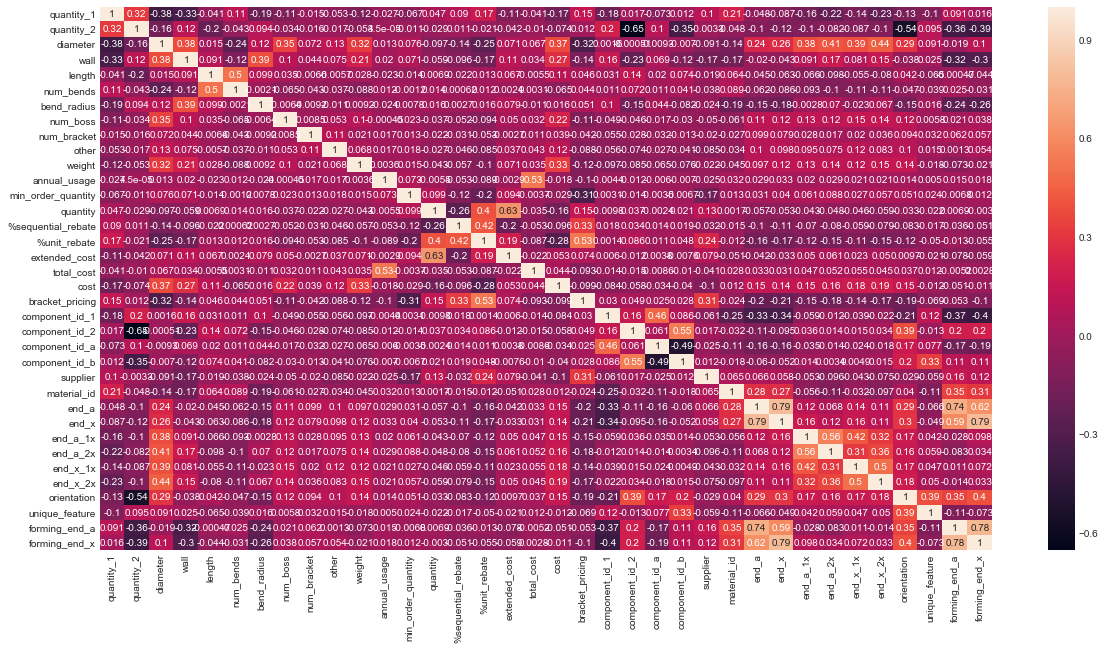

In [1427]:
plt.figure(figsize= (20,10))
sns.heatmap(df_model_a.corr(), annot=True)

In [1428]:
# Model A:Something is wrong. Getting negative price. Some values are way off. 

In [1429]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
lr = LinearRegression()

X = df_model_a.drop(['tube_assembly_id','cost', 'quote_date'], axis = 1)
y = df_model_a['cost']

'''
#normalize Values
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
X_std = sc.fit_transform(X)
X = X_std
'''
#X_std_test= sc.fit_transform(X_test)
X_train, X_test, y_train , y_test = train_test_split(X,y,  test_size=0.20)

In [1430]:
X_train.shape, X_test.shape , y_train.shape, y_test.shape

((48545, 35), (12137, 35), (48545,), (12137,))

In [1431]:
run_model_a = lr.fit(X_train, y_train)

In [1432]:
#predict = run_model_a.predict(X_test)
print(lr.coef_, lr.intercept_)

[-2.60190498e-01 -1.10763833e+00  2.63443056e-01  4.87154421e+00
  4.02753576e-02 -4.31821627e-01 -1.50612808e-01  1.38808977e+01
 -1.62116115e+00  6.62740466e+00  1.59481556e+01 -6.78888967e-04
 -1.60083130e-01 -4.06054077e-02  1.10583782e-02 -2.06871642e-01
  7.46794238e-03  9.19443633e-05  1.38322135e+01 -2.06346564e-02
 -1.98456274e-03  6.63151641e-03  1.41218775e-02 -1.86194293e-01
  5.23831745e-01  6.22808588e-01  1.17514753e-01 -3.24481474e+00
  8.38710677e-01  5.61729732e+00  2.08309281e+00  2.08256933e+00
 -1.93900393e+00 -6.78735745e+00 -5.21631228e+00] 8.9238718555338


In [1433]:
list(zip(X, lr.coef_))

[('quantity_1', -0.26019049816476886),
 ('quantity_2', -1.1076383344537164),
 ('diameter', 0.2634430562991714),
 ('wall', 4.871544211660623),
 ('length', 0.04027535761812787),
 ('num_bends', -0.43182162677925623),
 ('bend_radius', -0.1506128084533916),
 ('num_boss', 13.880897744932165),
 ('num_bracket', -1.6211611514739852),
 ('other', 6.627404658814201),
 ('weight', 15.948155627531781),
 ('annual_usage', -0.0006788889673839952),
 ('min_order_quantity', -0.16008312957962545),
 ('quantity', -0.04060540771232576),
 ('%sequential_rebate', 0.011058378224846248),
 ('%unit_rebate', -0.20687164171627798),
 ('extended_cost', 0.007467942382276135),
 ('total_cost', 9.194436330294984e-05),
 ('bracket_pricing', 13.832213472639738),
 ('component_id_1', -0.020634656413446854),
 ('component_id_2', -0.0019845627440275002),
 ('component_id_a', 0.006631516412713866),
 ('component_id_b', 0.014121877523451355),
 ('supplier', -0.1861942926466264),
 ('material_id', 0.5238317445104153),
 ('end_a', 0.62280858

In [1434]:
y_pred = lr.predict(X_test)

In [1435]:
df_model_a['predict_cost']=pd.DataFrame(y_pred)

In [1455]:
df_model_a[['tube_assembly_id','quantity','bracket_pricing','cost','predict_cost']]

,tube_assembly_id,quantity,bracket_pricing,cost,predict_cost
0,TA-00002,1,1,21.905933,17.858637
2,TA-00002,2,1,12.341214,31.938976
4,TA-00002,5,1,6.601826,4.280575
6,TA-00002,10,1,4.687770,16.498375
8,TA-00002,25,1,3.541561,20.126643
10,TA-00002,50,1,3.224406,17.782420
12,TA-00002,100,1,3.082521,15.557065
14,TA-00002,250,1,2.999060,24.329190
16,TA-00004,1,1,21.972702,20.616612
18,TA-00004,2,1,12.407983,45.706224


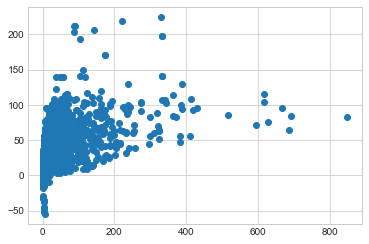

In [1437]:
plt.scatter(y_test,y_pred)

### Model B: Prepare table 2 for modelling

In [1438]:
df_final_2.isnull().sum()

tube_assembly_id             0
component_type_id         9129
quantity_1                1462
quantity_2               17299
diameter                     0
wall                         0
length                       0
num_bends                    0
bend_radius                  0
num_boss                     0
num_bracket                  0
other                        0
name                      9129
part_name                58964
weight                    9129
quote_date                   0
annual_usage                 0
min_order_quantity           0
quantity                     0
%sequential_rebate           0
%unit_rebate                 0
extended_cost                0
total_cost                   0
cost                         0
bracket_pricing_Yes          0
component_id_1_C-0004        0
component_id_1_C-0006        0
component_id_1_C-0007        0
component_id_1_C-0008        0
component_id_1_C-0011        0
                         ...  
end_x_EF-002                 0
end_x_EF

In [1439]:
#Replace quantity null values by 0
df_final_2[['quantity_1', 'quantity_2']]=df_final_2[['quantity_1', 'quantity_2']].fillna(0)

In [1440]:
df_final_2.head()

,tube_assembly_id,component_type_id,quantity_1,quantity_2,diameter,wall,length,num_bends,bend_radius,num_boss,...,end_x_EF-023,end_x_NONE,end_a_1x_Y,end_a_2x_Y,end_x_1x_Y,end_x_2x_Y,orientation_Yes,unique_feature_Yes,forming_end_a_Yes,forming_end_x_Yes
0,TA-00002,CP-028,2.0,0.0,6.35,0.71,137.0,8,19.05,0,...,0,0,0,0,0,0,0,0,1,1
2,TA-00002,CP-028,2.0,0.0,6.35,0.71,137.0,8,19.05,0,...,0,0,0,0,0,0,0,0,1,1
4,TA-00002,CP-028,2.0,0.0,6.35,0.71,137.0,8,19.05,0,...,0,0,0,0,0,0,0,0,1,1
6,TA-00002,CP-028,2.0,0.0,6.35,0.71,137.0,8,19.05,0,...,0,0,0,0,0,0,0,0,1,1
8,TA-00002,CP-028,2.0,0.0,6.35,0.71,137.0,8,19.05,0,...,0,0,0,0,0,0,0,0,1,1


In [1441]:
#Applying impute_weight Function: 
df_final_2['weight'] = df_final_2['weight'].transform(impute_weight)
print('Number of Missing Weight Values in the final table:', df_final_2['weight'].isnull().sum())

Number of Missing Weight Values in the final table: 0


In [1442]:
'''
#Convert tube_assembly_id datatupe from category to integer value: 
df_final_2['tube_assembly_id']=df_final_2['tube_assembly_id'].str.split('-').str.get(1)
df_final_2['tube_assembly_id']= pd.to_numeric(df_final_2['tube_assembly_id']).astype(np.int64)
df_final_2['tube_assembly_id'].dtype

'''

"\n#Convert tube_assembly_id datatupe from category to integer value: \ndf_final_2['tube_assembly_id']=df_final_2['tube_assembly_id'].str.split('-').str.get(1)\ndf_final_2['tube_assembly_id']= pd.to_numeric(df_final_2['tube_assembly_id']).astype(np.int64)\ndf_final_2['tube_assembly_id'].dtype\n\n"

In [1443]:
#Drop categorical columns from df_final_1 and stre df_model for modelling: 
df_model_b= df_final_2.drop(['component_type_id','name', 'part_name'], axis = 1)

In [1444]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
lr_b = LinearRegression()

X_b = df_model_b.drop(['tube_assembly_id','cost', 'quote_date'], axis = 1)
y_b = df_model_b['cost']
X_train_b, X_test_b, y_train_b , y_test_b = train_test_split(X_b,y_b, test_size=0.20)

In [1445]:
X_train_b.shape, X_test_b.shape , y_train_b.shape, y_test_b.shape

((48545, 2330), (12137, 2330), (48545,), (12137,))

In [1446]:
"""
#normalize Values
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
X_std_train_b = sc.fit_transform(X_train_b)
X_std_test_b= sc.fit_transform(X_test_b)
"""

'\n#normalize Values\nfrom sklearn.preprocessing import StandardScaler\nsc = StandardScaler()\nX_std_train_b = sc.fit_transform(X_train_b)\nX_std_test_b= sc.fit_transform(X_test_b)\n'

In [1447]:
run_model_b = lr_b.fit(X_train_b, y_train_b)

In [1448]:
#predict = run_model_a.predict(X_test)
print(lr_b.coef_, lr_b.intercept_)

[ 2.05000618e-03 -1.69880820e+00  2.59182198e-01 ...  3.43536316e+07
 -8.84001720e+06  5.63878877e+06] 6316593.580297321


In [1449]:
list(zip(X_b, lr.coef_))

[('quantity_1', -0.26019049816476886),
 ('quantity_2', -1.1076383344537164),
 ('diameter', 0.2634430562991714),
 ('wall', 4.871544211660623),
 ('length', 0.04027535761812787),
 ('num_bends', -0.43182162677925623),
 ('bend_radius', -0.1506128084533916),
 ('num_boss', 13.880897744932165),
 ('num_bracket', -1.6211611514739852),
 ('other', 6.627404658814201),
 ('weight', 15.948155627531781),
 ('annual_usage', -0.0006788889673839952),
 ('min_order_quantity', -0.16008312957962545),
 ('quantity', -0.04060540771232576),
 ('%sequential_rebate', 0.011058378224846248),
 ('%unit_rebate', -0.20687164171627798),
 ('extended_cost', 0.007467942382276135),
 ('total_cost', 9.194436330294984e-05),
 ('bracket_pricing_Yes', 13.832213472639738),
 ('component_id_1_C-0004', -0.020634656413446854),
 ('component_id_1_C-0006', -0.0019845627440275002),
 ('component_id_1_C-0007', 0.006631516412713866),
 ('component_id_1_C-0008', 0.014121877523451355),
 ('component_id_1_C-0011', -0.1861942926466264),
 ('component_i

In [1450]:
y_pred_b = lr_b.predict(X_test_b)
df_model_b['predict_cost_b']=pd.DataFrame(y_pred_b)

In [1456]:
df_model_b[['tube_assembly_id','bracket_pricing_Yes','quantity','cost' ,'predict_cost_b']]

,tube_assembly_id,bracket_pricing_Yes,quantity,cost,predict_cost_b
0,TA-00002,1,1,21.905933,7.467957
2,TA-00002,1,2,12.341214,25.085169
4,TA-00002,1,5,6.601826,-0.570534
6,TA-00002,1,10,4.687770,7.198104
8,TA-00002,1,25,3.541561,3.265893
10,TA-00002,1,50,3.224406,2.716491
12,TA-00002,1,100,3.082521,6.136052
14,TA-00002,1,250,2.999060,13.443015
16,TA-00004,1,1,21.972702,26.846137
18,TA-00004,1,2,12.407983,4.073984


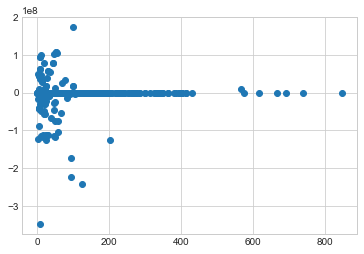

In [1452]:
plt.scatter(y_test_b,y_pred_b)